In [ ]:
# %matplotlib widget


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import math
import seaborn as sns
import json
import matplotlib.ticker as ticker


project_root = "."

pattern_configs = {
    "llm":{
        "task_order_list" : f"{project_root}/llm/llm_script_order.json",
        "csv_file_path" : f'{project_root}/fastflow_plots/llm_wf_2s_tr_estimated.csv',
        "plot_file_name" : 'llm_3d_relationship_files.pdf',
        "file_group_patterns" : [
            ".*.json",
            # ".*config.json",
            # "special_.*_map.json",
            # "tokenizer_config.json",
            "default_exp.*.arrow",
            ".*.safetensors",
            "optimizer.pt",
            "scheduler.pt",
            "vocab.json",
            "paper.pdf",
            ".*.txt",
        ],
        "result_path": f"./llm_plots"
    }
}

# Define file grouping file_group_patterns


FLOW_SCALE = 1000

def shorten_task_name(name):
    parts = name.split("_")
    # print(f"Original parts: {parts}")
    shortened = [p[:10] for i, p in enumerate(parts) if i % 2 == 0 or i == len(parts) - 1]
    # print(f"Shortened: {shortened}")
    return "_".join(shortened)

In [4]:

# Read CSV file
# csv_file_path = '{project_root}/fastflow_plots/par_9000_1n_pfs_ps300_fixed.csv'
# plot_file_name = '9000_3d_relationship_files.pdf'

# csv_file_path = '{project_root}/fastflow_plots/summer_sam_4n_pfs_s9_tr_estimated.csv'
# plot_file_name = 'pyflex_3d_relationship_files.pdf'

CURR_WF = "llm" # pyflex, ddmd, 1kgenome

csv_file_path = pattern_configs[CURR_WF]["csv_file_path"]
plot_file_name = pattern_configs[CURR_WF]["plot_file_name"]
file_group_patterns = pattern_configs[CURR_WF]["file_group_patterns"]
task_order_file = pattern_configs[CURR_WF]["task_order_list"]
extension_grouping = pattern_configs[CURR_WF].get("extension_grouping", False)
result_path = pattern_configs[CURR_WF].get("result_path", "./result_plots")

df = pd.read_csv(csv_file_path)


In [5]:
df.size, df.shape, df.columns, df['operation'].unique()

# Replace with shortened task name in all taskName columns
short_taskName_dict = {
    "finetune": "tune",
    "inference": "infer",
}

# Replace task names in the DataFrame
df['taskName'] = df['taskName'].replace(short_taskName_dict)
# Replace task names in the DataFrame
df['prevTask'] = df['prevTask'].replace(short_taskName_dict)


In [6]:
# Analyze Dataframe Info:

# # of unique Stages
unique_stages = df['stageOrder'].unique()
# # of unique Tasks
unique_tasks = df['taskName'].unique()
# # Task instance count based on dominant I/O type
task_instance_counts = (
    df.groupby(['taskName', 'operation'])
    .size()
    .unstack(fill_value=0)
    .max(axis=1)
)

# If needed as a total count
total_task_instances = task_instance_counts.sum()

# # of I/O entries (rows in the DataFrame)
num_io_entries = df.shape[0]
# # of unique I/O files
unique_files = df['fileName'].unique()
# # average file resues: calculate the average number of times each file is reused for each unique file
avg_file_reuses = df.groupby('fileName').size().mean()
# Total I/O size
total_io_size = df['aggregateFilesizeMB'].sum()

# Print all the information
print("=========================================")
print(f"Number of unique stages: {len(unique_stages)}")
# print(f"Number of unique tasks: {len(unique_tasks)}")
print(f"Total task instances: {total_task_instances}")
print(f"Total I/O size (MB): {total_io_size:.2f}")
print(f"Total I/O size (GB): {total_io_size / 1024:.2f}")
# print(f"Number of I/O entries: {num_io_entries}")
print(f"Number of unique I/O files: {len(unique_files)}")
print(f"Average file reuses: {avg_file_reuses:.2f}")
print("=========================================")
# Print unique stages and tasks and File names
print(f"Unique stages: {unique_stages}")
print(f"Unique tasks: {unique_tasks}")
print(f"Unique file names: {unique_files}")

Number of unique stages: 2
Total task instances: 18
Total I/O size (MB): 33174.79
Total I/O size (GB): 32.40
Number of unique I/O files: 12
Average file reuses: 2.17
Unique stages: [2 1]
Unique tasks: ['infer' 'tune']
Unique file names: ['tokenizer_config.json' 'merges.txt' 'vocab.json'
 'generation_config.json' 'tokenizer.json' 'config.json'
 'special_tokens_map.json' 'model.safetensors' 'optimizer.pt'
 'scheduler.pt' 'default_experiment-1-0.arrow' 'paper.pdf']


In [7]:
# get the 95%ile of the aggregateFilesizeMB
# 50%ile
percentile_50 = df['aggregateFilesizeMB'].quantile(0.50)
print(f"50th percentile of aggregateFilesizeMB: {percentile_50:.2f}")
# 75th percentile
percentile_75 = df['aggregateFilesizeMB'].quantile(0.75)
print(f"75th percentile of aggregateFilesizeMB: {percentile_75:.2f}")
# 85th percentile
percentile_85 = df['aggregateFilesizeMB'].quantile(0.85)
print(f"85th percentile of aggregateFilesizeMB: {percentile_85:.2f}")
# 95th percentile
percentile_95 = df['aggregateFilesizeMB'].quantile(0.95)
# 99th percentile
percentile_99 = df['aggregateFilesizeMB'].quantile(0.99)
print(f"95th percentile of aggregateFilesizeMB: {percentile_95:.2f}")
print(f"99th percentile of aggregateFilesizeMB: {percentile_99:.2f}")




# get the max trMiB of taskName tracksingle
max_trMiB = df[df['taskName'] == 'IterDe']['trMiB'].max()
print(f"Max trMiB of taskName tracksingle: {max_trMiB:.2f}")

max_aggregateFilesizeMB = df[df['taskName'] == 'IterDe']['aggregateFilesizeMB'].max()
print(f"Max aggregateFilesizeMB of taskName tracksingle: {max_aggregateFilesizeMB:.2f}")

# get max trMiB of df 
max_trMiB = df['trMiB'].max()
print(f"Max trMiB of all tasks: {max_trMiB:.2f}")

# get min trMiB of df
min_trMiB = df['trMiB'].min()
print(f"Min trMiB of all tasks: {min_trMiB:.2f}")

# get 50 percentile of trMiB
percentile_50 = df['trMiB'].quantile(0.50)
print(f"50th percentile of trMiB: {percentile_50:.2f}")

# get 75 percentile of trMiB
percentile_75 = df['trMiB'].quantile(0.75)
print(f"75th percentile of trMiB: {percentile_75:.2f}")

# get 85 percentile of trMiB
percentile_85 = df['trMiB'].quantile(0.85)
print(f"85th percentile of trMiB: {percentile_85:.2f}")

# get average trMiB of all tasks
avg_trMiB = df['trMiB'].mean()
print(f"Avg trMiB of all tasks: {avg_trMiB:.2f}")

# get the average trMiB of all unique tasks
avg_trMiB = df.groupby('taskName')['trMiB'].mean()
print(f"Avg trMiB of all unique tasks: {avg_trMiB}")
print("==========================================")

unique_tasks = df['taskName'].unique()

for task in unique_tasks:
    avg_trMiB = df[df['taskName'] == task]['trMiB'].mean()
    print(f"Avg trMiB of task {task}: {avg_trMiB:.2f}")
    # get the average opCount of task
    avg_opCount = df[df['taskName'] == task]['opCount'].mean()
    print(f"Avg opCount of task {task}: {avg_opCount:.2f}")
    # get number of entries of task
    num_entries = df[df['taskName'] == task].shape[0]
    print(f"Number of entries of task {task}: {num_entries}")
    # get the average aggregateFilesizeMB of task
    avg_aggregateFilesizeMB = df[df['taskName'] == task]['aggregateFilesizeMB'].mean()
    print(f"Avg aggregateFilesizeMB of task {task}: {avg_aggregateFilesizeMB:.2f}")
    # get number of read entries of task
    num_read_entries = df[(df['taskName'] == task) & (df['operation'] == 1)].shape[0]
    print(f"Number of read entries of task {task}: {num_read_entries}")
    # get number of write entries of task
    num_write_entries = df[(df['taskName'] == task) & (df['operation'] == 0)].shape[0]
    print(f"Number of write entries of task {task}: {num_write_entries}")
    
    # get the parallelized trMiB of task
    task_parallelism = df[df['taskName'] == task]['parallelism'].mean()
    print(f"Parallelism of task {task}: {task_parallelism:.2f}")
    if task_parallelism == 1:
        task_total_trMiB = df[df['taskName'] == task]['trMiB'].mean()
        print(f"Total trMiB of task {task}: {task_total_trMiB:.2f}")
    else:
        task_total_trMiB = df[df['taskName'] == task]['trMiB'].sum()
        print(f"Total trMiB of task {task}: {task_total_trMiB:.2f}")
    task_parallelised_trMiB = task_total_trMiB / task_parallelism
    print(f"Parallelized trMiB of task {task}: {task_parallelised_trMiB:.2f}")
    
    # read operation average trMiB
    read_trMiB = df[(df['taskName'] == task) & (df['operation'] == 1)]['trMiB'].mean()
    print(f"Avg read trMiB of task {task}: {read_trMiB:.2f}")
    
    # write operation average trMiB
    write_trMiB = df[(df['taskName'] == task) & (df['operation'] == 0)]['trMiB'].mean()
    print(f"Avg write trMiB of task {task}: {write_trMiB:.2f}")
    
    print("==========================================")


50th percentile of aggregateFilesizeMB: 426.39
75th percentile of aggregateFilesizeMB: 2973.39
85th percentile of aggregateFilesizeMB: 2973.39
95th percentile of aggregateFilesizeMB: 2973.39
99th percentile of aggregateFilesizeMB: 2973.39
Max trMiB of taskName tracksingle: nan
Max aggregateFilesizeMB of taskName tracksingle: nan
Max trMiB of all tasks: 4296.03
Min trMiB of all tasks: 3017.05
50th percentile of trMiB: 3170.85
75th percentile of trMiB: 3170.85
85th percentile of trMiB: 3452.15
Avg trMiB of all tasks: 3283.41
Avg trMiB of all unique tasks: taskName
infer    3466.000451
tune     3126.910971
Name: trMiB, dtype: float64
Avg trMiB of task infer: 3466.00
Avg opCount of task infer: 97.33
Number of entries of task infer: 12
Avg aggregateFilesizeMB of task infer: 286.21
Number of read entries of task infer: 4
Number of write entries of task infer: 8
Parallelism of task infer: 1.00
Total trMiB of task infer: 3466.00
Parallelized trMiB of task infer: 3466.00
Avg read trMiB of task 

/tmp/ipykernel_440661/2058681503.py:46: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  plt.scatter(


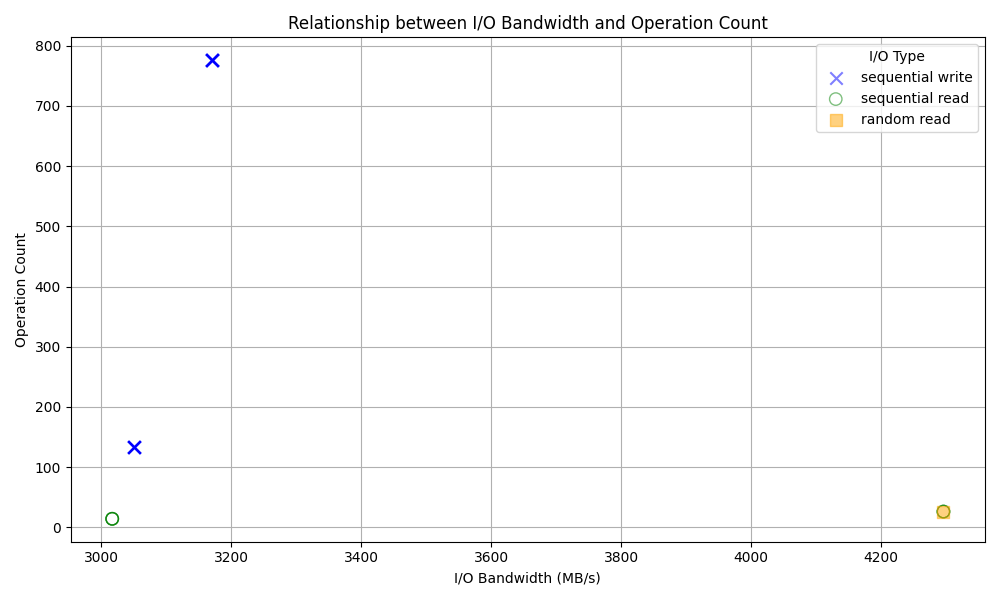

In [8]:
# Define mapping of operation and randomness to I/O type
def map_io_type(row):
    if row['operation'] == 0 and row['randomOffset'] == 0:
        return 'sequential write'
    elif row['operation'] == 0 and row['randomOffset'] == 1:
        return 'random write'
    elif row['operation'] == 1 and row['randomOffset'] == 0:
        return 'sequential read'
    elif row['operation'] == 1 and row['randomOffset'] == 1:
        return 'random read'
    else:
        return 'unknown'

# Apply the mapping
df['io_type'] = df.apply(map_io_type, axis=1)

# Assign colors and markers to each I/O type
io_color_map = {
    'sequential write': 'blue',
    'random write': 'purple',
    'sequential read': 'green',
    'random read': 'orange',
}
io_marker_map = {
    'sequential write': 'x',
    'random write': 'D',
    'sequential read': 'o',
    'random read': 's',
}
io_short_name_map = {
    "sequential write": 'Seq W',
    "random write": 'Rand W',
    "sequential read": 'Seq R',
    "random read": 'Rand R',
}
df['color'] = df['io_type'].map(io_color_map)
df['marker'] = df['io_type'].map(io_marker_map)

# 2D plot: Relationship between I/O Bandwidth and Operation Count
plt.figure(figsize=(10, 6))

for io_type in df['io_type'].unique():
    subset = df[df['io_type'] == io_type]
    marker = subset['marker'].iloc[0]
    facecolor = 'none' if marker == 'o' else subset['color'].iloc[0]
    plt.scatter(
        subset['trMiB'], 
        subset['opCount'], 
        label=io_type, 
        edgecolor=subset['color'].iloc[0], 
        facecolors=facecolor,
        marker=marker,
        s=80,
        alpha=0.5
    )

plt.title('Relationship between I/O Bandwidth and Operation Count')
plt.xlabel('I/O Bandwidth (MB/s)')
plt.ylabel('Operation Count')
plt.grid(True)
plt.legend(title="I/O Type")
plt.tight_layout()
plt.show()


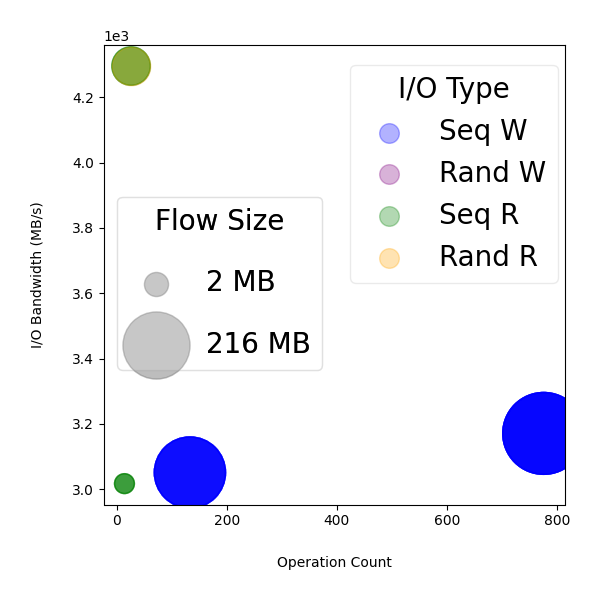

In [9]:
import matplotlib.pyplot as plt

# 2D plot: x = opCount, y = trMiB, point size = aggregateFilesizeMB, color = io_type
fig, ax = plt.subplots(figsize=(6, 6))

size_scale = FLOW_SCALE

# Plot actual data for present I/O types
for io_type, color in io_color_map.items():
    subset = df[df['io_type'] == io_type]
    
    if not subset.empty:
        sizes = np.log10(subset['aggregateFilesizeMB']) * size_scale  # Adjust as needed

        ax.scatter(
            subset['opCount'],
            subset['trMiB'],
            s=sizes,
            label=io_short_name_map[io_type],
            color=color,
            marker='o',
            alpha=0.3
        )
    else:
        ax.scatter([], [], s=80, label=io_short_name_map[io_type], color=color, marker='o', alpha=0.3)

# Font size settings
plt.rc('font', size=20)
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)

ax.set_xlabel('Operation Count', labelpad=20)
ax.set_ylabel('I/O Bandwidth (MB/s)', labelpad=20)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# # Set log scale for x-axis
# ax.set_xscale('log')
# ====== Create fixed-size legend entries for I/O types =======
legend_handles = []
for io_type, color in io_color_map.items():
    label = io_short_name_map[io_type]
    handle = plt.scatter([], [], s=200, color=color, label=label, alpha=0.3)  # Fixed size
    legend_handles.append(handle)
    
# First legend: I/O types
legend1 = ax.legend(
    handles=legend_handles,
    title="I/O Type",
    loc='center',
    bbox_to_anchor=(0.36, 0.72, 0.8, 0.0),
    framealpha=0.4,
    facecolor='white'
)
ax.add_artist(legend1)

# Second legend: Flow Size (MB)
# Choose some representative values to show in the legend
# Get non-zero aggregateFilesizeMB values
flow_data = df['aggregateFilesizeMB'].dropna().sort_values()
if not flow_data.empty:
    min_val = flow_data.min()
    if min_val == 0:
        min_val = np.percentile(flow_data, 1)
    max_val = flow_data.max()
    mid1 = np.percentile(flow_data, 30)
    mid2 = np.percentile(flow_data, 66)
    flow_sizes = [math.ceil(min_val), int(mid1)]
else:
    flow_sizes = [10, 50, 100, 500]  # fallback
    
scatter_proxies = [plt.scatter([], [], s=np.log10(fs) * size_scale, color='gray', alpha=0.3) for fs in flow_sizes]
labels = [f"{fs} MB" for fs in flow_sizes]

legend2 = ax.legend(scatter_proxies, labels, title="Flow Size", loc='upper left', 
                    bbox_to_anchor=(0, 0.7, 0.8, 0.0), framealpha=0.4, facecolor='white',
                    labelspacing=1.2)
ax.add_artist(legend2)

plt.tight_layout()
plt.show()
fig.savefig(f"{result_path}/op_{plot_file_name}")


/tmp/ipykernel_440661/1956951582.py:12: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


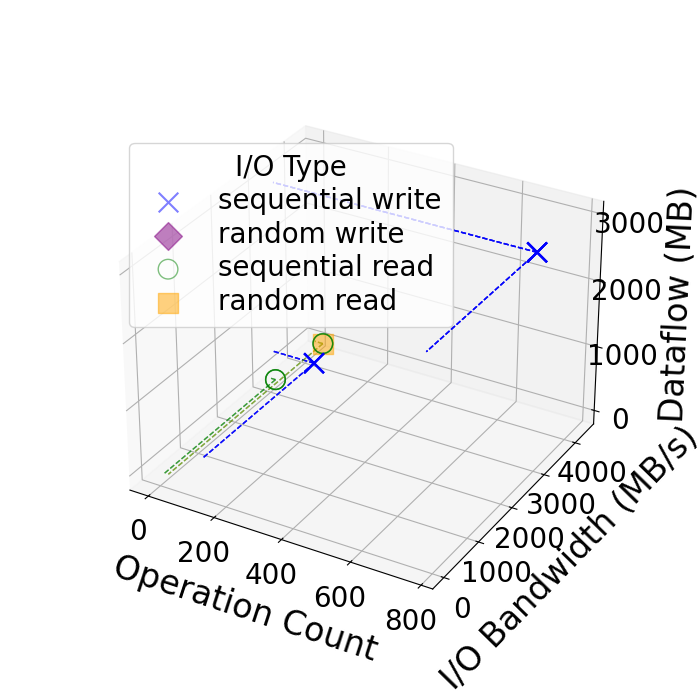

In [10]:
# 3D plot: Relationship between aggregateFilesizeMB, stageOrder, and trMiB
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot for each defined I/O type, whether or not data exists
for io_type, color in io_color_map.items():
    subset = df[df['io_type'] == io_type]
    marker = io_marker_map[io_type]
    facecolor = 'none' if marker == 'o' else color

    if not subset.empty:
        ax.scatter(
            subset['opCount'],
            subset['trMiB'],
            subset['aggregateFilesizeMB'],
            label=io_type,
            edgecolor=color,  
            facecolors=facecolor,
            marker=marker,
            s=200,
            alpha=0.5
        )

        # Add dashed lines from each point to the x and y axes
        for _, row in subset.iterrows():
            x = row['opCount']
            y = row['trMiB']
            z = row['aggregateFilesizeMB']
            # Line to x-axis (z stays same, y drops to 0)
            ax.plot([x, x], [y, 0], [z, z], linestyle='dashed', color=color,   alpha=0.3, linewidth=1)
            # Line to y-axis (z stays same, x drops to 0)
            ax.plot([x, 0], [y, y], [z, z], linestyle='dashed', color=color,   alpha=0.3, linewidth=1)

    else:
        # Dummy point for legend
        ax.scatter([], [], [],
                   label=io_type,
                   edgecolor=color,  
                   facecolors=facecolor,
                   marker=marker,
                   s=200,
                   alpha=0.5)

# Font size settings
plt.rc('font', size=20)
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)

ax.set_xlabel('Operation Count', labelpad=15)
ax.set_ylabel('I/O Bandwidth (MB/s)', labelpad=15)
ax.set_zlabel('Dataflow (MB)', labelpad=15)

ax.legend(title="I/O Type", loc="right", bbox_to_anchor=(0.3, 0.72, 0.4, 0.0),
          framealpha=0.8, facecolor='white', fontsize=20, labelspacing=0.2)

# plt.tight_layout()
plt.show()
fig.savefig(f"{result_path}/op_{plot_file_name}")


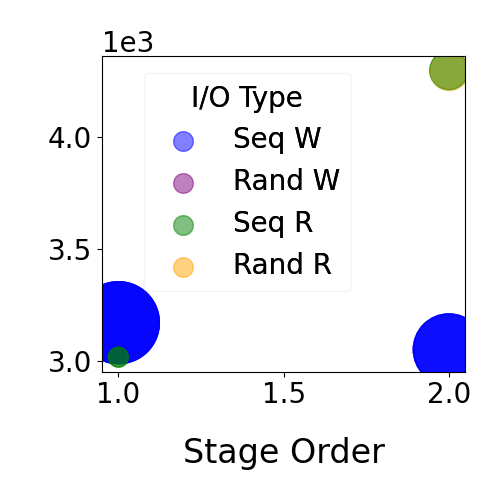

In [11]:
import matplotlib.pyplot as plt

# 2D plot: x = opCount, y = trMiB, point size = aggregateFilesizeMB, color = io_type
fig, ax = plt.subplots(figsize=(5, 5))

size_scale = FLOW_SCALE

# Plot actual data for present I/O types
for io_type, color in io_color_map.items():
    subset = df[df['io_type'] == io_type]
    
    if not subset.empty:
        sizes = np.log10(subset['aggregateFilesizeMB']) * size_scale

        ax.scatter(
            subset['stageOrder'],
            subset['trMiB'],
            s=sizes,
            label=io_short_name_map[io_type],
            color=color,
            marker='o',
            alpha=0.3
        )
    else:
        ax.scatter([], [], s=80, label=io_short_name_map[io_type], color=color, marker='o', alpha=0.3)


# Font size settings
plt.rc('font', size=20)
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)

ax.set_xlabel('Stage Order', labelpad=20)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

# ax.set_ylabel('I/O Bandwidth (MB/s)', labelpad=20)

# # First legend: I/O types
# legend1 = ax.legend(title="I/O Type", loc='center', bbox_to_anchor=(0.1, 0.8, 0.8, 0.0), framealpha=0.1, facecolor='yellow')
# ax.add_artist(legend1)

# ====== Create fixed-size legend entries for I/O types =======
legend_handles = []
for io_type, color in io_color_map.items():
    label = io_short_name_map[io_type]
    handle = plt.scatter([], [], s=200, color=color, label=label, alpha=0.3)  # Fixed size
    legend_handles.append(handle)
    
# First legend: I/O types
legend1 = ax.legend(
    handles=legend_handles,
    title="I/O Type",
    loc='center',
    bbox_to_anchor=(0, 0.6, 0.8, 0.0),
    framealpha=0.1,
    facecolor='white'
)
ax.add_artist(legend1)


plt.tight_layout()
plt.show()
fig.savefig(f"{result_path}/stage_{plot_file_name}")


/tmp/ipykernel_440661/1834822818.py:12: UserWarning: You passed a edgecolor/edgecolors ('blue') for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  ax.scatter(


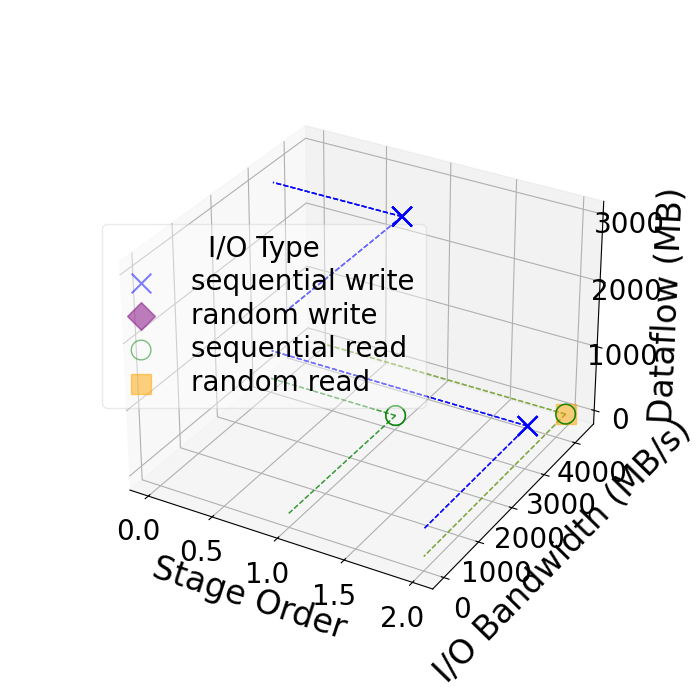

In [12]:
# 3D plot: Relationship between aggregateFilesizeMB, stageOrder, and trMiB
fig = plt.figure(figsize=(7, 7))
ax = fig.add_subplot(111, projection='3d')

# Plot for each defined I/O type, whether or not data exists
for io_type, color in io_color_map.items():
    subset = df[df['io_type'] == io_type]
    marker = io_marker_map[io_type]
    facecolor = 'none' if marker == 'o' else color

    if not subset.empty:
        ax.scatter(
            subset['stageOrder'],
            subset['trMiB'],
            subset['aggregateFilesizeMB'],
            label=io_type,
            edgecolor=color,  
            facecolors=facecolor,
            marker=marker,
            s=200,
            alpha=0.5
        )
        # Add dashed lines from each point to the x and y axes
        for _, row in subset.iterrows():
            x = row['stageOrder']
            y = row['trMiB']
            z = row['aggregateFilesizeMB']
            # Line to x-axis (z stays same, y drops to 0)
            ax.plot([x, x], [y, 0], [z, z], linestyle='dashed', color=color,   alpha=0.3, linewidth=1)
            # Line to y-axis (z stays same, x drops to 0)
            ax.plot([x, 0], [y, y], [z, z], linestyle='dashed', color=color,   alpha=0.3, linewidth=1)
    else:
        # Dummy point for legend
        ax.scatter([], [], [],
                   label=io_type,
                   edgecolor=color,  
                   facecolors=facecolor,
                   marker=marker,
                   s=200,
                   alpha=0.5)

# Font size settings
plt.rc('font', size=20)
plt.rc('axes', titlesize=24)
plt.rc('axes', labelsize=24)
plt.rc('xtick', labelsize=20)
plt.rc('ytick', labelsize=20)
plt.rc('legend', fontsize=20)

# Switched axes
ax.set_xlabel('Stage Order', labelpad=10)
ax.set_ylabel('I/O Bandwidth (MB/s)', labelpad=10)
ax.set_zlabel('Dataflow (MB)', labelpad=10)

ax.legend(title="I/O Type", loc="right", bbox_to_anchor=(0.25, 0.57, 0.4, 0.0),
          labelspacing=0.2, framealpha=0.4, facecolor='white', columnspacing=0.2,
          )

# plt.tight_layout()
plt.show()
fig.savefig(f"{result_path}/stage_{plot_file_name}")


{'finetune': {'stage_order': 1, 'parallelism': 1, 'num_tasks': 1, 'predecessors': {'initial_data': {'inputs': ['config.json', 'special_tokens_map.json', 'tokenizer_config.json']}}, 'outputs': ['config.json', 'default_experiment.*\\.arrow', 'model.safetensors', 'optimizer.pt', 'scheduler.pt', 'special_tokens_map.json', 'tokenizer_config.json', 'vocab.json']}, 'inference': {'stage_order': 2, 'parallelism': 1, 'num_tasks': 1, 'predecessors': {'finetune': {'inputs': ['config.json', 'tokenizer.json', 'tokenizer_config.json', 'model.safetensors', 'paper.pdf']}}, 'outputs': ['config.json', 'generation_config.json', 'model.safetensors', 'special_tokens_map.json', 'tokenizer.json', 'tokenizer_config.json', 'vocab.json']}}
Unique tasks: ['infer', 'tune']
Group 1: ['infer', 'tune']


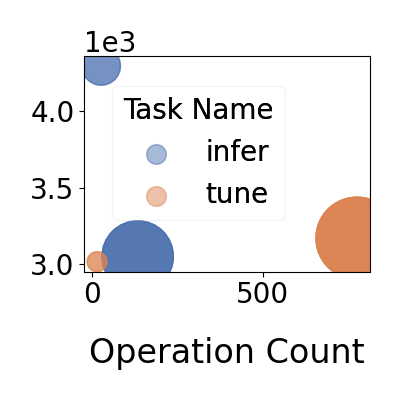

In [13]:
# Load task ordering json file
task_order_dict = {}
with open(task_order_file) as f:
    task_order_dict = json.load(f)

print(task_order_dict)

size_scale = FLOW_SCALE

# Ensure tasks are ordered based on task_order_dict
unique_tasks = sorted(
    df['taskName'].unique(), 
    key=lambda t: task_order_dict.get(t, {}).get('stage_order', float('inf'))
)

print(f"Unique tasks: {unique_tasks}")
if not unique_tasks:
    print("No tasks found, skipping plotting.")
    exit()

num_tasks = len(unique_tasks)
palette = sns.color_palette("deep", 9)  # Use 9 distinct colors

task_group_count = 15
task_groups = [unique_tasks[i:i+task_group_count] for i in range(0, num_tasks, task_group_count)]


for group_idx, task_group in enumerate(task_groups):
    valid_tasks = [task for task in task_group if task in df['taskName'].values]
    print(f"Group {group_idx+1}: {valid_tasks}")
    if not valid_tasks:
        print(f"Skipping empty group {group_idx+1}")
        continue

    fig, ax = plt.subplots(figsize=(4, 4))

    color_map = {task: palette[i % len(palette)] for i, task in enumerate(valid_tasks)}

    for task in valid_tasks:
        subset = df[df['taskName'] == task]
        if subset.empty:
            print(f"Skipping task '{task}' (no data)")
            continue

        sizes = np.log10(subset['aggregateFilesizeMB']) * size_scale

        ax.scatter(
            subset['opCount'],
            subset['trMiB'],
            s=sizes,
            label=shorten_task_name(task),
            color=color_map[task],
            marker='o',
            alpha=0.3
        )

    # Font size and labels
    plt.rc('font', size=20)
    plt.rc('axes', titlesize=24)
    plt.rc('axes', labelsize=24)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.rc('legend', fontsize=20)

    ax.set_xlabel('Operation Count', labelpad=20)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

    # ax.set_ylabel('I/O Bandwidth (MB/s)', labelpad=20)

    # First legend: Task Name (fixed size dots, only color varies)
    task_legend_proxies = [
        plt.scatter([], [], s=200, color=color_map[task], alpha=0.3, label=shorten_task_name(task))
        for task in valid_tasks
    ]
    legend1 = ax.legend(handles=task_legend_proxies, title="Task Name", loc='center', 
                        bbox_to_anchor=(0, 0.55, 0.8, 0.0), framealpha=0.1, facecolor='white')
    ax.add_artist(legend1)

    # Second legend: Flow Size (MB)
    flow_data = df['aggregateFilesizeMB'].dropna().sort_values()
    if not flow_data.empty:
        min_val = flow_data.min()
        if min_val == 0:
            min_val = np.percentile(flow_data, 1)
        max_val = flow_data.max()
        mid1 = np.percentile(flow_data, 33)
        mid2 = np.percentile(flow_data, 66)
        flow_sizes = [math.ceil(min_val), int(mid1), int(mid2), int(max_val)]
    else:
        flow_sizes = [10, 50, 100, 500]  # fallback

    # size_legend_proxies = [
    #     plt.scatter([], [], s=fs * size_scale, color='gray', alpha=0.3) for fs in flow_sizes
    # ]
    # size_labels = [f"{fs} MB" for fs in flow_sizes]
    # legend2 = ax.legend(size_legend_proxies, size_labels, title="Flow Size", loc='center', bbox_to_anchor=(0.36, 0.43, 0.8, 0.0))
    # ax.add_artist(legend2)

    plt.tight_layout()
    plt.show()
    fig.savefig(f'{result_path}/taskColor_group{group_idx+1}_' + plot_file_name)

{'finetune': {'stage_order': 1, 'parallelism': 1, 'num_tasks': 1, 'predecessors': {'initial_data': {'inputs': ['config.json', 'special_tokens_map.json', 'tokenizer_config.json']}}, 'outputs': ['config.json', 'default_experiment.*\\.arrow', 'model.safetensors', 'optimizer.pt', 'scheduler.pt', 'special_tokens_map.json', 'tokenizer_config.json', 'vocab.json']}, 'inference': {'stage_order': 2, 'parallelism': 1, 'num_tasks': 1, 'predecessors': {'finetune': {'inputs': ['config.json', 'tokenizer.json', 'tokenizer_config.json', 'model.safetensors', 'paper.pdf']}}, 'outputs': ['config.json', 'generation_config.json', 'model.safetensors', 'special_tokens_map.json', 'tokenizer.json', 'tokenizer_config.json', 'vocab.json']}}
Unique tasks: ['infer', 'tune']
Group 1: ['infer', 'tune']


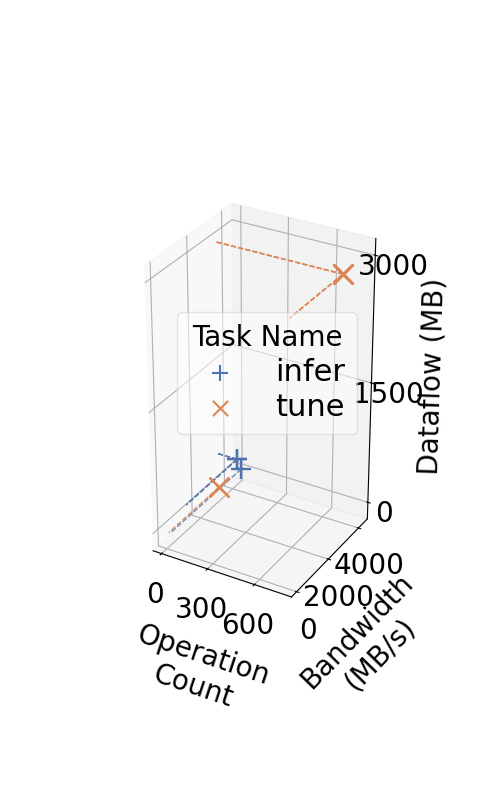

In [73]:
# Load task ordering json file
task_order_dict = {}
with open(task_order_file) as f:
    task_order_dict = json.load(f)

print(task_order_dict)

# Ensure tasks are ordered based on task_order_dict
unique_tasks = sorted(
    df['taskName'].unique(), 
    key=lambda t: task_order_dict.get(t, {}).get('stage_order', float('inf'))
)

# Debugging output
print(f"Unique tasks: {unique_tasks}")  
if not unique_tasks:
    print("No tasks found, skipping plotting.")
    exit()

num_tasks = len(unique_tasks)

# Define color palette and markers
palette = sns.color_palette("deep", num_tasks)
# markers = ['+', 'x', '3', '2', '*', '^', 's', 'o', 'D', 'p', 'h']

# Split tasks into groups of 5
task_group_count = 10
task_groups = [unique_tasks[i:i+task_group_count] for i in range(0, num_tasks, task_group_count)]

for group_idx, task_group in enumerate(task_groups):


    # Filter out empty groups
    valid_tasks = [task for task in task_group if task in df['taskName'].values]
    print(f"Group {group_idx+1}: {valid_tasks}")
    if not valid_tasks:
        print(f"Skipping empty group {group_idx+1}")
        continue

    # 3D plot: Relationship between aggregateFilesizeMB, totalTime, and trMiB
    fig = plt.figure(figsize=(5, 8))
    ax = fig.add_subplot(111, projection='3d')

    x = df['trMiB']
    y = df['opCount']
    z = df['aggregateFilesizeMB']
    markers = ['+', 'x', '3', '2', '*']  # Add more markers as needed

    # Generate color and marker maps for current group
    color_map = {task: palette[i % len(palette)] for i, task in enumerate(valid_tasks)}
    marker_map = {task: markers[i % len(markers)] for i, task in enumerate(valid_tasks)}

    df['color'] = df['taskName'].map(lambda task: color_map.get(task, 'black'))  # Black if not found
    df['marker'] = df['taskName'].map(lambda task: marker_map.get(task, 'o'))  # 'o' if not found

    for task in valid_tasks:
        subset = df[df['taskName'] == task]
        if subset.empty:
            print(f"Skipping task '{task}' (no data)")
            continue
        
        opCount = subset['opCount']
        trMiB = subset['trMiB']
        filesize = subset['aggregateFilesizeMB']

        for x, y, z in zip(opCount, trMiB, filesize):
            ax.scatter(x, y, z,
                    color=color_map[task],
                    marker=marker_map[task],
                    s=200)

            # Dashed line to x-axis (z stays same, y drops to 0)
            ax.plot([x, x], [y, 0], [z, z], linestyle='dashed', color=color_map[task], alpha=0.3, linewidth=1)

            # Dashed line to y-axis (z stays same, x drops to 0)
            ax.plot([x, 0], [y, y], [z, z], linestyle='dashed', color=color_map[task], alpha=0.3, linewidth=1)
        ax.scatter([], [], [], label=shorten_task_name(task), color=color_map[task], marker=marker_map[task], s=120)


    # Set labels and title
    plt.rc('font', size=20)
    plt.rc('axes', titlesize=20)
    plt.rc('axes', labelsize=20)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.rc('legend', fontsize=22)
    
    
    ax.set_xlabel('Operation\nCount', labelpad=20)
    ax.set_ylabel('Bandwidth\n(MB/s)', labelpad=20)
    ax.set_zlabel('Dataflow (MB)', labelpad=20)
    # use only 3 ticks for all axes
    ax.xaxis.set_major_locator(ticker.MaxNLocator(3))
    ax.yaxis.set_major_locator(ticker.MaxNLocator(3))
    ax.zaxis.set_major_locator(ticker.MaxNLocator(3))

    ax.legend(title="Task Name", loc="right", bbox_to_anchor=(0, 0.58, 0.8, 0.0),
              labelspacing=0.2, framealpha=0.5, 
              ) # (0, 0.83, 0.8, 0.0) (0, 0.6, 1.3, 0.0)
    # fig.tight_layout()
    # plt.figure(constrained_layout=True)
    ax.set_box_aspect([1, 1, 2])  # Aspect ratio is 1:1:1

    plt.show()
    fig.savefig(f'{result_path}/taskColor_group{group_idx+1}_'+plot_file_name)


In [15]:
import re
import os

# Compile regex patterns once
compiled_patterns = [(pattern, re.compile(pattern)) for pattern in file_group_patterns]

def extract_group(filename):
    for pattern_str, pattern in compiled_patterns:
        if pattern.search(filename):
            return pattern_str.replace("\\", "")  # Remove backslashes
    print(f"Filename '{filename}' did not match any patterns.")
    return "group_other"


# Apply to dataframe
df["file_group"] = df["fileName"].apply(extract_group)

# Check results
print("Unique file groups:")
print(df["file_group"].value_counts())

def padded_range(series, pad_ratio=0.05):
    """Return min and max with padding based on data range."""
    min_val = series.min()
    max_val = series.max()
    pad = (max_val - min_val) * pad_ratio
    return min_val - pad, max_val + pad

Unique file groups:
file_group
.*.json                18
.*.txt                  2
.*.safetensors          2
optimizer.pt            1
scheduler.pt            1
default_exp.*.arrow     1
paper.pdf               1
Name: count, dtype: int64


Unique groups [7]: ['.*.json' '.*.txt' '.*.safetensors' 'optimizer.pt' 'scheduler.pt'
 'default_exp.*.arrow' 'paper.pdf']


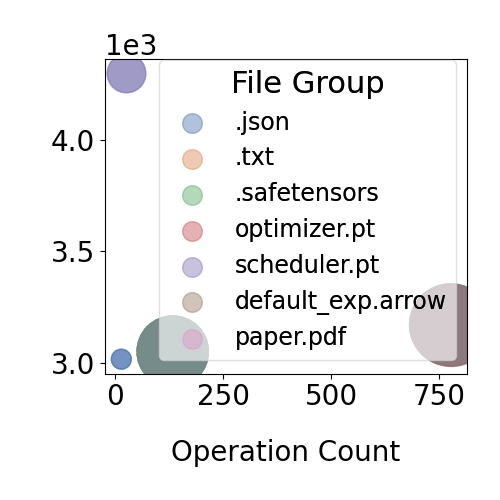

In [16]:
# Generate a color palette
unique_groups = df["file_group"].unique()
print(f"Unique groups [{len(unique_groups)}]: {unique_groups}")

# Exclude certain groups (e.g., for 1000 Genome)
exclude_groups = ['AFR', 'EAS', 'SAS', 'ALL', 'EUR', 'GBR', 'AMR']
unique_groups = [g for g in unique_groups if g not in exclude_groups]

num_groups = len(unique_groups)
palette = sns.color_palette("deep", 9)  # Limit to 9 distinct colors

# Group batches
file_group_count = 20
group_batches = [unique_groups[i:i+file_group_count] for i in range(0, len(unique_groups), file_group_count)]

size_scale = FLOW_SCALE

for batch_idx, group_batch in enumerate(group_batches):
    valid_groups = [group for group in group_batch if group in df["file_group"].values]
    if not valid_groups:
        print(f"Skipping empty group {batch_idx+1}")
        continue

    fig, ax = plt.subplots(figsize=(5, 5))
    
    color_map = {group: palette[i % len(palette)] for i, group in enumerate(valid_groups)}

    for group in valid_groups:
        subset = df[df["file_group"] == group]
        if subset.empty:
            print(f"Skipping group '{group}' (no data)")
            continue

        sizes = np.log10(subset['aggregateFilesizeMB']) * size_scale

        ax.scatter(
            subset["opCount"],
            subset["trMiB"],
            s=sizes,
            label=group,
            color=color_map[group],
            marker='o',
            alpha=0.3
        )

    # Font settings
    plt.rc('font', size=22)
    plt.rc('axes', titlesize=24)
    plt.rc('axes', labelsize=24)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.rc('legend', fontsize=17)

    ax.set_xlabel("Operation Count", labelpad=20)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

    # ax.set_ylabel("I/O Bandwidth (MB/s)", labelpad=20)
    
    # First legend: File Group colors (with fixed-size dummy points)
    scatter_proxies = [
        plt.scatter([], [], s=200, color=color_map[group], alpha=0.3, label=group.replace(".*", ""))
        for group in valid_groups
    ]
    # First legend: File Group colors
    legend1 = ax.legend(handles=scatter_proxies, title="File Group", loc='center', 
                        bbox_to_anchor=(0.16, 0.52, 0.8, 0.0), framealpha=0.4, facecolor='white')

    ax.add_artist(legend1)

    # Second legend: Flow Size (MB)
    flow_data = df["aggregateFilesizeMB"].dropna().sort_values()
    if not flow_data.empty:
        min_val = flow_data.min()
        if min_val == 0:
            min_val = np.percentile(flow_data, 1)
        max_val = flow_data.max()
        mid1 = np.percentile(flow_data, 33)
        mid2 = np.percentile(flow_data, 66)
        flow_sizes = [math.ceil(min_val), int(mid1), int(mid2), int(max_val)]
    else:
        flow_sizes = [10, 50, 100, 500]  # fallback

    plt.tight_layout()
    plt.savefig(f'{result_path}/fileColor_group{batch_idx+1}_op_' + plot_file_name)
    plt.show()

Unique groups [7]: ['.*.json' '.*.txt' '.*.safetensors' 'optimizer.pt' 'scheduler.pt'
 'default_exp.*.arrow' 'paper.pdf']


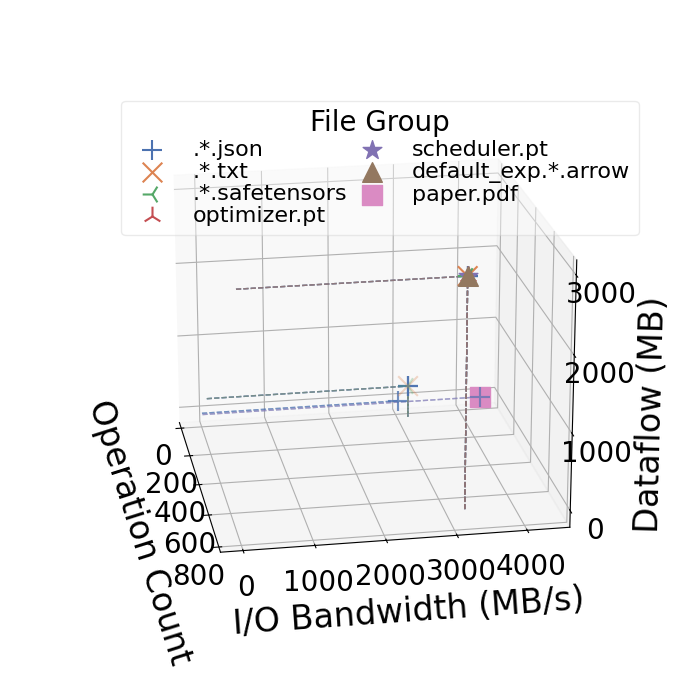

In [54]:
# Generate a color palette
unique_groups = df["file_group"].unique()
print(f"Unique groups [{len(unique_groups)}]: {unique_groups}")

num_groups = len(unique_groups)

# Define color palette and markers
palette = sns.color_palette("deep", num_groups)
markers = ['+', 'x', '3', '2', '*', '^', 's', 'o', 'D', 'p', 'h']

# Groups to exclude for 1000 genome
exclude_groups = ['AFR', 'EAS', 'SAS', 'ALL', 'EUR', 'GBR', 'AMR']
# Remove them from unique_groups
unique_groups = [g for g in unique_groups if g not in exclude_groups]

# Split file groups into groups of n
file_group_count = 20
group_batches = [unique_groups[i:i+file_group_count] for i in range(0, num_groups, file_group_count)]

for batch_idx, group_batch in enumerate(group_batches):
    # Skip empty groups
    valid_groups = [group for group in group_batch if group in df["file_group"].values]
    if not valid_groups:
        print(f"Skipping empty group {batch_idx+1}")
        continue

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')

    # Generate color and marker maps for current group
    color_map = {group: palette[i % len(palette)] for i, group in enumerate(valid_groups)}
    marker_map = {group: markers[i % len(markers)] for i, group in enumerate(valid_groups)}

    # Assign colors and markers
    df["color"] = df["file_group"].map(lambda group: color_map.get(group, 'black'))
    df["marker"] = df["file_group"].map(lambda group: marker_map.get(group, 'o'))

    for group in valid_groups:
            subset = df[df["file_group"] == group]
            if subset.empty:
                print(f"Skipping group '{group}' (no data)")
                continue

            ax.scatter(subset['opCount'], subset['trMiB'], subset['aggregateFilesizeMB'], 
                    label=group, 
                    color=color_map[group],  
                    marker=marker_map[group],  
                    s=200)

            # Add dashed lines from each point to the XY plane
            for _, row in subset.iterrows():
                x = row['opCount']
                y = row['trMiB']
                z = row['aggregateFilesizeMB']

                # Line to X-axis (constant y, z = 0)
                ax.plot([x, x], [y, y], [0, z], linestyle='dashed', color=color_map[group], alpha=0.3, linewidth=1)
                # Line to Y-axis (constant x, z = 0)
                ax.plot([x, x], [0, y], [z, z], linestyle='dashed', color=color_map[group], alpha=0.3, linewidth=1)
                # Optional: Line to XY plane (z = 0)
                ax.plot([x, x], [y, y], [z, 0], linestyle='dashed', color=color_map[group], alpha=0.3, linewidth=1)
            
    
    # Set font sizes
    plt.rc('font', size=20)
    plt.rc('axes', titlesize=24)
    plt.rc('axes', labelsize=24)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.rc('legend', fontsize=16)

    # Set axis labels
    ax.set_xlabel('Operation Count', labelpad=15)
    ax.set_ylabel('I/O Bandwidth (MB/s)', labelpad=15)
    ax.set_zlabel('Dataflow (MB)', labelpad=15)
    
    # Ensure y-axis only shows integers
    # ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # ax.set_xlim(df['opCount'].max() * 1.1, 0)

    # Legend updated to reflect file groups
    ax.legend(title="File Group", loc="upper right", bbox_to_anchor=(0.64, 0.99, 0.4, 0.0),
              ncol=2, framealpha=0.4, facecolor='white', labelspacing=0.1, columnspacing=0.1,
              )
    
    ax.set_box_aspect([1, 1, 0.8])  # Aspect ratio for better visualization
    
    # rotate graph to right
    ax.view_init(elev=20, azim=350)
    
    # Show and save figure
    fig.savefig(f'{result_path}/fileColor_group{batch_idx+1}_op_'+plot_file_name)
    plt.show()


Unique groups [7]: ['.*.json' '.*.txt' '.*.safetensors' 'optimizer.pt' 'scheduler.pt'
 'default_exp.*.arrow' 'paper.pdf']


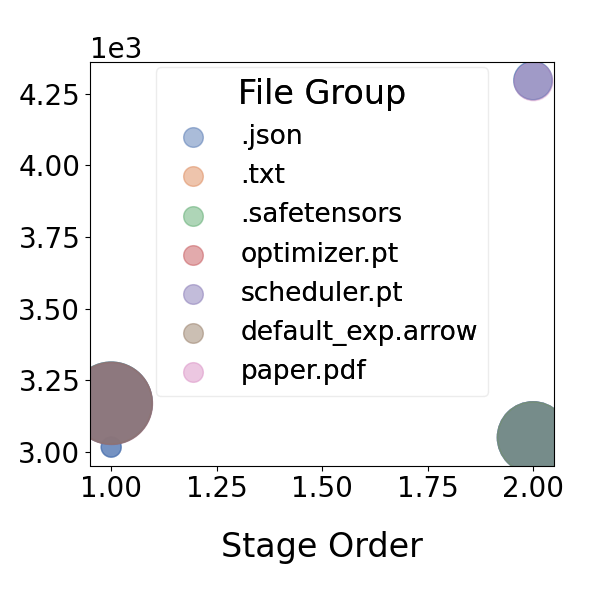

In [18]:
# Generate a color palette
unique_groups = df["file_group"].unique()
print(f"Unique groups [{len(unique_groups)}]: {unique_groups}")

# Exclude certain groups (e.g., for 1000 Genome)
exclude_groups = ['AFR', 'EAS', 'SAS', 'ALL', 'EUR', 'GBR', 'AMR']
unique_groups = [g for g in unique_groups if g not in exclude_groups]

num_groups = len(unique_groups)
palette = sns.color_palette("deep", 9)  # Limit to 9 distinct colors

# Group batches
file_group_count = 20
group_batches = [unique_groups[i:i+file_group_count] for i in range(0, len(unique_groups), file_group_count)]

size_scale = FLOW_SCALE

for batch_idx, group_batch in enumerate(group_batches):
    valid_groups = [group for group in group_batch if group in df["file_group"].values]
    if not valid_groups:
        print(f"Skipping empty group {batch_idx+1}")
        continue

    fig, ax = plt.subplots(figsize=(6, 6))
    
    color_map = {group: palette[i % len(palette)] for i, group in enumerate(valid_groups)}

    for group in valid_groups:
        subset = df[df["file_group"] == group]
        if subset.empty:
            print(f"Skipping group '{group}' (no data)")
            continue

        sizes = np.log10(subset['aggregateFilesizeMB']) * size_scale

        ax.scatter(
            subset["stageOrder"],
            subset["trMiB"],
            s=sizes,
            label=group,
            color=color_map[group],
            marker='o',
            alpha=0.3
        )

    # Font settings
    plt.rc('font', size=24)
    plt.rc('axes', titlesize=24)
    plt.rc('axes', labelsize=24)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.rc('legend', fontsize=19)

    ax.set_xlabel("Stage Order", labelpad=20)
    ax.ticklabel_format(axis='y', style='sci', scilimits=(0, 0))

    # ax.set_ylabel("I/O Bandwidth (MB/s)", labelpad=20)
    
    # First legend: File Group colors (with fixed-size dummy points)
    scatter_proxies = [
        plt.scatter([], [], s=200, color=color_map[group], alpha=0.3, label=group.replace(".*", ""))
        for group in valid_groups
    ]
    # First legend: File Group colors
    legend1 = ax.legend(handles=scatter_proxies, title="File Group", loc='center', 
                        bbox_to_anchor=(0.1, 0.58, 0.8, 0.0), framealpha=0.2, facecolor='white')

    ax.add_artist(legend1)

    # Second legend: Flow Size (MB)
    flow_data = df["aggregateFilesizeMB"].dropna().sort_values()
    if not flow_data.empty:
        min_val = flow_data.min()
        if min_val == 0:
            min_val = np.percentile(flow_data, 1)
        max_val = flow_data.max()
        mid1 = np.percentile(flow_data, 33)
        mid2 = np.percentile(flow_data, 66)
        flow_sizes = [math.ceil(min_val), int(mid1), int(mid2), int(max_val)]
    else:
        flow_sizes = [10, 50, 100, 500]  # fallback

    plt.tight_layout()
    plt.savefig(f'{result_path}/fileColor_group{batch_idx+1}_stage_' + plot_file_name)
    plt.show()

Unique groups [7]: ['.*.json' '.*.txt' '.*.safetensors' 'optimizer.pt' 'scheduler.pt'
 'default_exp.*.arrow' 'paper.pdf']


/tmp/ipykernel_440661/3772734422.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure(figsize=(7,7))


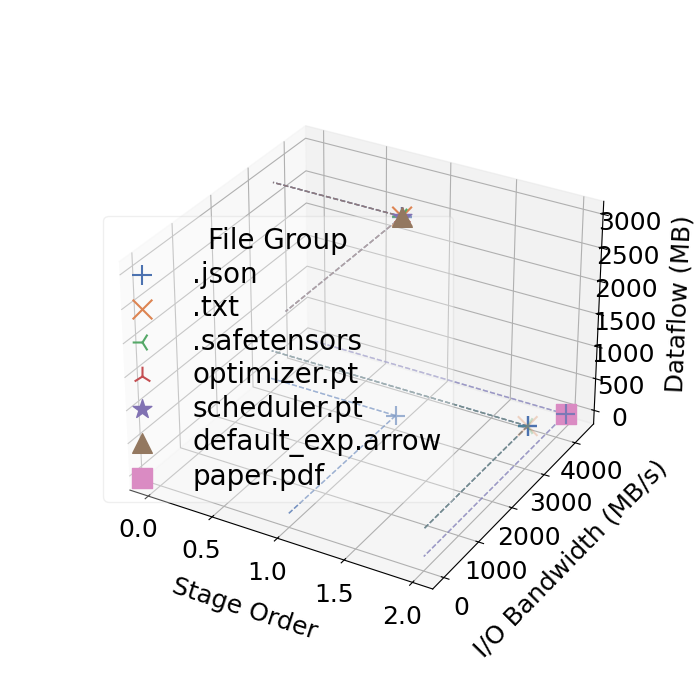

In [32]:
# Generate a color palette
unique_groups = df["file_group"].unique()
print(f"Unique groups [{len(unique_groups)}]: {unique_groups}")

num_groups = len(unique_groups)

# Define color palette and markers
# Define color palette and markers
palette = sns.color_palette("deep", num_groups)
markers = ['+', 'x', '3', '2', '*', '^', 's', 'o', 'D', 'p', 'h']

# Groups to exclude for 1000 genome
exclude_groups = ['AFR', 'EAS', 'SAS', 'ALL', 'EUR', 'GBR', 'AMR']
# Remove them from unique_groups
unique_groups = [g for g in unique_groups if g not in exclude_groups]

# unique_groups = ["optimizer.pt"]

# Split file groups into groups of n
file_group_count = 20
group_batches = [unique_groups[i:i+file_group_count] for i in range(0, num_groups, file_group_count)]

for batch_idx, group_batch in enumerate(group_batches):
    # Skip empty groups
    valid_groups = [group for group in group_batch if group in df["file_group"].values]
    if not valid_groups:
        print(f"Skipping empty group {batch_idx+1}")
        continue

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')

    # Generate color and marker maps for current group
    color_map = {group: palette[i % len(palette)] for i, group in enumerate(valid_groups)}
    marker_map = {group: markers[i % len(markers)] for i, group in enumerate(valid_groups)}

    # Assign colors and markers
    df["color"] = df["file_group"].map(lambda group: color_map.get(group, 'black'))
    df["marker"] = df["file_group"].map(lambda group: marker_map.get(group, 'o'))

    # Iterate through the valid file groups
    for group in valid_groups:
        subset = df[df["file_group"] == group]
        if subset.empty:
            print(f"Skipping group '{group}' (no data)")
            continue

        # ax.scatter(subset['trMiB'], subset['stageOrder'], subset['aggregateFilesizeMB'], 
        ax.scatter(subset['stageOrder'], subset['trMiB'], subset['aggregateFilesizeMB'], 
                   label=group.replace("_.*","").replace(".*", ""),
                   color=color_map[group],  
                   marker=marker_map[group],  
                   s=200)
        # Add dashed lines from each point to the x and y axes
        for _, row in subset.iterrows():
            x = row['stageOrder']
            y = row['trMiB']
            z = row['aggregateFilesizeMB']
            # Line to x-axis (z stays same, y drops to 0)
            ax.plot([x, x], [y, 0], [z, z], linestyle='dashed', color=color_map[group], alpha=0.3, linewidth=1)
            # Line to y-axis (z stays same, x drops to 0)
            ax.plot([x, 0], [y, y], [z, z], linestyle='dashed', color=color_map[group], alpha=0.3, linewidth=1)
    
    # Set font sizes
    plt.rc('font', size=20)
    plt.rc('axes', titlesize=18)
    plt.rc('axes', labelsize=18)
    plt.rc('xtick', labelsize=18)
    plt.rc('ytick', labelsize=18)
    plt.rc('legend', fontsize=20)

    # Set axis labels
    ax.set_xlabel('Stage Order', labelpad=15)
    ax.set_ylabel('I/O Bandwidth (MB/s)', labelpad=15)
    ax.set_zlabel('Dataflow (MB)', labelpad=15)
    
    # Ensure y-axis only shows integers
    # ax.xaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # use less ticks on the y-axis
    
    

    # Legend updated to reflect file groups
    ax.legend(title="File Group", loc="center", bbox_to_anchor=(0.15, 0.49, 0.4, 0.0),
              labelspacing=0.2, framealpha=0.3,columnspacing=0.1,
              )

    # plt.figure(constrained_layout=True)
    
    # use tight_layout to avoid overlap
    # fig.tight_layout()

    # Show and save figure
    fig.savefig(f'{result_path}/fileColor_group{batch_idx+1}_stage_'+plot_file_name)
    plt.show()

    



Unique groups [7]: ['.*.json' '.*.txt' '.*.safetensors' 'optimizer.pt' 'scheduler.pt'
 'default_exp.*.arrow' 'paper.pdf']


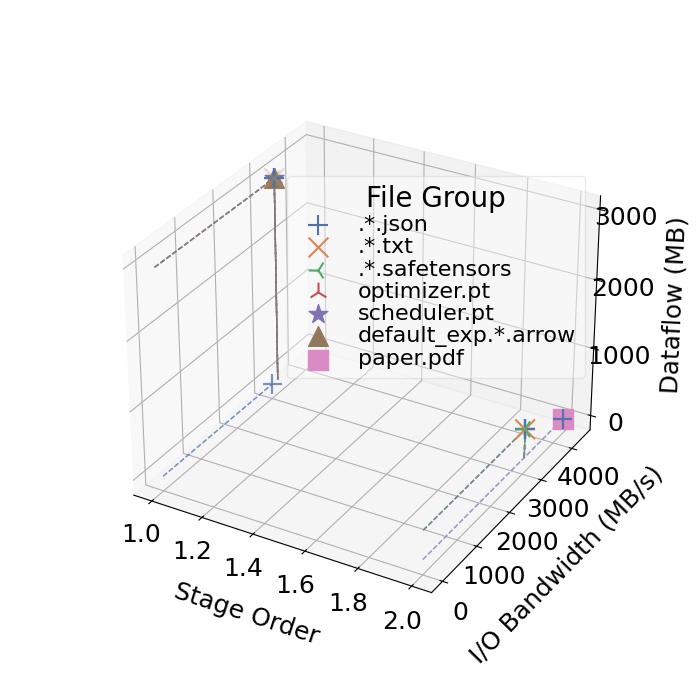

In [20]:
# Generate a color palette
unique_groups = df["file_group"].unique()
print(f"Unique groups [{len(unique_groups)}]: {unique_groups}")

num_groups = len(unique_groups)

# Define color palette and markers
palette = sns.color_palette("deep", num_groups)
markers = ['+', 'x', '3', '2', '*', '^', 's', 'o', 'D', 'p', 'h']

# Groups to exclude for 1000 genome
exclude_groups = ['AFR', 'EAS', 'SAS', 'ALL', 'EUR', 'GBR', 'AMR']
# Remove them from unique_groups
unique_groups = [g for g in unique_groups if g not in exclude_groups]

# Split file groups into groups of n
file_group_count = 20
group_batches = [unique_groups[i:i+file_group_count] for i in range(0, num_groups, file_group_count)]

for batch_idx, group_batch in enumerate(group_batches):
    # Skip empty groups
    valid_groups = [group for group in group_batch if group in df["file_group"].values]
    if not valid_groups:
        print(f"Skipping empty group {batch_idx+1}")
        continue

    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111, projection='3d')

    # Generate color and marker maps for current group
    color_map = {group: palette[i % len(palette)] for i, group in enumerate(valid_groups)}
    marker_map = {group: markers[i % len(markers)] for i, group in enumerate(valid_groups)}

    # Assign colors and markers
    df["color"] = df["file_group"].map(lambda group: color_map.get(group, 'black'))
    df["marker"] = df["file_group"].map(lambda group: marker_map.get(group, 'o'))

    for group in valid_groups:
            subset = df[df["file_group"] == group]
            if subset.empty:
                print(f"Skipping group '{group}' (no data)")
                continue

            ax.scatter(subset['stageOrder'], subset['trMiB'], subset['aggregateFilesizeMB'], 
                    label=group, 
                    color=color_map[group],  
                    marker=marker_map[group],  
                    s=200)

            # Add dashed lines from each point to the XY plane
            for _, row in subset.iterrows():
                x = row['stageOrder']
                y = row['trMiB']
                z = row['aggregateFilesizeMB']

                # Line to X-axis (constant y, z = 0)
                ax.plot([x, x], [y, y], [0, z], linestyle='dashed', color=color_map[group], alpha=0.3, linewidth=1)
                # Line to Y-axis (constant x, z = 0)
                ax.plot([x, x], [0, y], [z, z], linestyle='dashed', color=color_map[group], alpha=0.3, linewidth=1)
                # Optional: Line to XY plane (z = 0)
                ax.plot([x, x], [y, y], [z, 0], linestyle='dashed', color=color_map[group], alpha=0.3, linewidth=1)
            
    
    # Set font sizes
    plt.rc('font', size=20)
    plt.rc('axes', titlesize=24)
    plt.rc('axes', labelsize=24)
    plt.rc('xtick', labelsize=20)
    plt.rc('ytick', labelsize=20)
    plt.rc('legend', fontsize=16)

    # Set axis labels
    ax.set_xlabel('Stage Order', labelpad=15)
    ax.set_ylabel('I/O Bandwidth (MB/s)', labelpad=15)
    ax.set_zlabel('Dataflow (MB)', labelpad=15)
    
    # Ensure y-axis only shows integers
    # ax.yaxis.set_major_locator(ticker.MaxNLocator(integer=True))
    # ax.set_xlim(df['opCount'].max() * 1.1, 0)

    # Legend updated to reflect file groups
    ax.legend(title="File Group", loc="upper right", bbox_to_anchor=(0.54, 0.85, 0.4, 0.0),
              framealpha=0.4, facecolor='white', labelspacing=0.1, columnspacing=0.1,
              )
    
    ax.set_box_aspect([1, 1, 0.8])  # Aspect ratio for better visualization
    
    # Show and save figure
    fig.savefig(f'{result_path}/fileColor_group{batch_idx+1}_stage_'+plot_file_name)
    plt.show()


In [21]:
manual_pairs = {
    ("initial_data", "tune") : "1-1",
    ("initial_data", "infer") : "1-1",
    ("tune", "infer") : "1-1",
    ("tune", "final_data") : "1-1",
    ("infer", "final_data") : "1-1",
}


# Combine based on your manual producer-consumer task pairs
rows = []
for producer, consumer in manual_pairs.keys():
    pc_label = producer + '→' + consumer
    
    if consumer == "final_data":
        df_subset_write = df[(df['operation'] == 0) & (df['taskName'] == producer) & (df['prevTask'] == consumer)]

        if df_subset_write.empty:
            print(f"Skipping special pair ({pc_label}): no data")
            continue

        if df_subset_write['parallelism'].mean() > 1:
            subset_write_bw = df_subset_write['trMiB'].sum()
        else:
            subset_write_bw = df_subset_write['trMiB'].mean()

        consumer_file_group = df_subset_write['file_group'].unique()

        row = {
            'producerTask': producer,
            'consumerTask': consumer,
            'producer_parallelism': df_subset_write['parallelism'].mean(),
            'consumer_parallelism': 0,
            'transferSize': df_subset_write['transferSize'].sum(),
            'aggregateFilesizeMB': df_subset_write['aggregateFilesizeMB'].sum(),
            'totalTime': df_subset_write['totalTime'].sum(),
            'opCount': df_subset_write['opCount'].sum(),
            'trMiB': subset_write_bw,
            'stageOrder_read': int(df_subset_write['stageOrder'].mean()),
            'stageOrder_write': int(df_subset_write['stageOrder'].mean()),
            'pcPair': pc_label,
            'file_groups': consumer_file_group,
        }
        rows.append(row)
        continue
    if producer == "initial_data":        
        df_subset_read = df[(df['operation'] == 1) & (df['taskName'] == consumer) & (df['prevTask'] == producer)]
        if df_subset_read.empty:
            print(f"Skipping special pair ({pc_label}): no data")
            # Printe the dataframe's taskName and prevTask
            # print(f"Producer: {producer}, Consumer: {consumer}, df_subset_read: {df_subset_read[['prevTask', 'taskName']]}")
            continue
        
        if df_subset_read['parallelism'].mean() > 1:
            subset_read_bw = df_subset_read['trMiB'].sum() if not df_subset_read.empty else 0
        else:
            subset_read_bw = df_subset_read['trMiB'].mean() if not df_subset_read.empty else 0
        
        consumer_file_group = df_subset_read['file_group'].unique()
        
        row = {
            'producerTask': producer,
            'consumerTask': consumer,
            'producer_parallelism': 0,
            'consumer_parallelism': df_subset_read['parallelism'].mean(),
            'transferSize': df_subset_read['transferSize'].sum(),
            'aggregateFilesizeMB': df_subset_read['aggregateFilesizeMB'].sum(),
            'totalTime': df_subset_read['totalTime'].sum(),
            'opCount': df_subset_read['opCount'].sum(),
            'trMiB': subset_read_bw,
            'stageOrder_read': int(df_subset_read['stageOrder'].mean()),
            'stageOrder_write': int(df_subset_read['stageOrder'].mean()),
            'pcPair': pc_label,
            'file_groups': consumer_file_group,
        }
        rows.append(row)
        continue
    else:
        # Regular handling
        df_subset_pc_read = df[(df['operation'] == 1) & (df['taskName'] == consumer) & (df['prevTask'] == producer)]
        # check if any of the dataframes are empty
        if df_subset_pc_read.empty:
            print(f"Skipping pair ({pc_label}): no data")
            # Printe the dataframe's taskName and prevTask
            print(f"Producer: {producer}, Consumer: {consumer}, df_subset_pc: {df_subset_pc_read[['prevTask', 'taskName']]}")
            continue
        # get list of unique file names
        consumer_files = df_subset_pc_read['fileName'].unique()
        consumer_file_group = df_subset_pc_read['file_group'].unique()
        # get the dataframe with the same file names
        df_subset_pc_write = df[(df['operation'] == 0) & (df['taskName'] == producer) ] # this workflow only one consumer
        
        if df_subset_pc_write.empty:
            print(f"Skipping pair ({pc_label}): no data")
            # Printe the dataframe's taskName and prevTask
            print(f"Producer: {producer}, Consumer: {consumer}, df_subset_pc: {df_subset_pc_write[['prevTask', 'taskName']]}")
            continue
        
        
        producer_parallelism = df_subset_pc_write['parallelism'].mean()
        consumer_parallelism = df_subset_pc_read['parallelism'].mean()
        # print(f"Producer: {producer}, Consumer: {consumer}, Producer Parallelism: {producer_parallelism}, Consumer Parallelism: {consumer_parallelism}")
        
        if producer_parallelism > 1:
            # If parallelism > 1, use sum
            subset_write_bw = df_subset_pc_write['trMiB'].sum() if not df_subset_pc_write.empty else 0
        else:
            # If parallelism <= 1, use mean
            subset_write_bw = df_subset_pc_write['trMiB'].mean() if not df_subset_pc_write.empty else 0
        
        if consumer_parallelism > 1:
            # If parallelism > 1, use sum
            subset_read_bw = df_subset_pc_read['trMiB'].sum() if not df_subset_pc_read.empty else 0
        else:
            # If parallelism <= 1, use mean
            subset_read_bw = df_subset_pc_read['trMiB'].mean() if not df_subset_pc_read.empty else 0

        row = {
            'producerTask': producer,
            'consumerTask': consumer,
            'producer_parallelism': producer_parallelism,
            'consumer_parallelism': consumer_parallelism,
            'transferSize': df_subset_pc_write['transferSize'].mean() + df_subset_pc_read['transferSize'].mean(),
            'aggregateFilesizeMB': df_subset_pc_write['aggregateFilesizeMB'].sum() + df_subset_pc_read['aggregateFilesizeMB'].sum(),
            'totalTime': df_subset_pc_write['totalTime'].sum() + df_subset_pc_read['totalTime'].sum(),
            'opCount': df_subset_pc_write['opCount'].sum() + df_subset_pc_read['opCount'].sum(),
            'trMiB': (subset_write_bw + subset_read_bw) / 2,
            'stageOrder_read': int(df_subset_pc_read['stageOrder'].mean()),
            'stageOrder_write': int(df_subset_pc_write['stageOrder'].mean()),
            'pcPair': pc_label,
            'file_groups': consumer_file_group, # list of unique file groups
        }

        rows.append(row)

# Create DataFrame
df_pc = pd.DataFrame(rows)

# Show summary
print(f"Constructed producer-consumer DataFrame with {len(df_pc)} pairs.")
print(df_pc[['pcPair', 'aggregateFilesizeMB', 'totalTime', 'trMiB', 'producer_parallelism', 'consumer_parallelism']])

# Optional: create pair label
df_pc['pcPair'] = df_pc['producerTask'] + '→' + df_pc['consumerTask']

# Get unique producer-consumer pairs
unique_pairs = df_pc['pcPair'].unique()
if len(unique_pairs) == 0:
    print("No producer-consumer pairs available for plotting.")
    exit()

print(f"Unique producer-consumer pairs: {unique_pairs}")

print(df_pc)



Constructed producer-consumer DataFrame with 5 pairs.
               pcPair  aggregateFilesizeMB  totalTime        trMiB  \
0   initial_data→tune             6.417679   0.002127  3017.051488   
1  initial_data→infer             5.852847   0.001362  4296.033350   
2          tune→infer         29751.430669   9.381329  3733.444057   
3     tune→final_data          8920.161638   2.813173  3170.854765   
4    infer→final_data          3411.085541   1.118028  3050.984001   

   producer_parallelism  consumer_parallelism  
0                   0.0                   1.0  
1                   0.0                   1.0  
2                   1.0                   1.0  
3                   1.0                   0.0  
4                   1.0                   0.0  
Unique producer-consumer pairs: ['initial_data→tune' 'initial_data→infer' 'tune→infer' 'tune→final_data'
 'infer→final_data']
   producerTask consumerTask  producer_parallelism  consumer_parallelism  \
0  initial_data         tune       

In [22]:
print("=== aggregateFilesizeMB Range ===")
print(f"df_pc: min = {df_pc['aggregateFilesizeMB'].min():.2f}, max = {df_pc['aggregateFilesizeMB'].max():.2f}")
print(f"df   : min = {df['aggregateFilesizeMB'].min():.2f}, max = {df['aggregateFilesizeMB'].max():.2f}")


=== aggregateFilesizeMB Range ===
df_pc: min = 5.85, max = 29751.43
df   : min = 1.60, max = 2973.39


/tmp/ipykernel_440661/2020311463.py:81: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax.set_xlim(left=0, right=df_pc['opCount'].max() * 2)


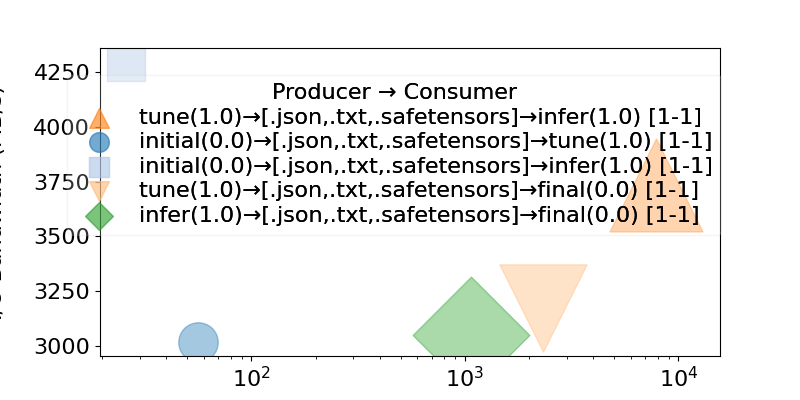

In [67]:
# Plot settings
palette = sns.color_palette("tab20", len(unique_pairs))
pair_group_count = 20
pair_groups = [unique_pairs[i:i + pair_group_count] for i in range(0, len(unique_pairs), pair_group_count)]

size_scale = FLOW_SCALE  # Control how large the bubbles appear


# Add marker styles
marker_styles = ['o', 's', '^', 'v', 'D', 'P', '*', 'X', 'h', '<', '>', 'p', 'H', '|', '_']
marker_map = {}

for group_idx, pair_group in enumerate(pair_groups):
    subset_group = df_pc[df_pc['pcPair'].isin(pair_group)]
    if subset_group.empty:
        print(f"Skipping empty group {group_idx + 1}")
        continue

    fig, ax = plt.subplots(figsize=(8, 4))

    color_map = {pair: palette[i % len(palette)] for i, pair in enumerate(pair_group)}
    marker_map = {pair: marker_styles[i % len(marker_styles)] for i, pair in enumerate(pair_group)}
    seen_labels = set()

    for _, row in subset_group.iterrows():
        pair_label = row['pcPair']
        producer, consumer = pair_label.split('→')
        short_producer = shorten_task_name(producer)
        short_consumer = shorten_task_name(consumer)

        pattern = manual_pairs.get((producer, consumer), "unknown")
        producer_parallelism = int(row['producer_parallelism']) if pd.notna(row['producer_parallelism']) else 1
        consumer_parallelism = int(row['consumer_parallelism']) if pd.notna(row['consumer_parallelism']) else 1
        if "gettrks" in producer:
            producer_parallelism = 1
        if "gettrks" in consumer:
            consumer_parallelism = 1

        # short_label = f"{short_producer}({producer_parallelism})→{short_consumer}({consumer_parallelism}) [{pattern}]"
        short_label = f"{short_producer}({producer_parallelism})→["
        if short_producer == "freq" or short_producer == "mut_olp":
            short_label += f"chr-.tar.gz,"
        else:
            for file_group in row['file_groups']:   
                short_label += f"{file_group},".replace("_.*", "").replace(".*","")
        # replace the last char with ]
        short_label = short_label[:-1] + "]"
        short_label += f"→{short_consumer}({consumer_parallelism}) [{pattern}]"
        
        show_label = pair_label not in seen_labels
        seen_labels.add(pair_label)

        trMiB = row['trMiB'] if pd.notna(row['trMiB']) else 0
        opCount = row['opCount'] if pd.notna(row['opCount']) else 0
        filesize = row['aggregateFilesizeMB'] if pd.notna(row['aggregateFilesizeMB']) else 0

        ax.scatter(
            opCount,
            trMiB,
            s=np.log10(filesize) * size_scale,
            color=color_map[pair_label],
            label=short_label if show_label else None,
            alpha=0.4,
            marker=marker_map[pair_label]
        )

    # Styling
    plt.rcParams.update({
        'font.size': 16,
        'axes.titlesize': 16,
        'axes.labelsize': 16,
        'xtick.labelsize': 16,
        'ytick.labelsize': 16,
        'legend.fontsize': 16
    })

    ax.set_xlabel('Operation Count (log)', labelpad=20)
    ax.set_ylabel('I/O Bandwidth (MB/s)', labelpad=20)
    ax.set_xscale('log')
    # set x axis limit
    ax.set_xlim(left=0, right=df_pc['opCount'].max() * 2)

    # Create legend with markers
    handles = []
    labels = []
    for pair_label in seen_labels:
        producer, consumer = pair_label.split('→')
        short_producer = shorten_task_name(producer)
        short_consumer = shorten_task_name(consumer)
        pattern = manual_pairs.get((producer, consumer), "unknown")
        producer_parallelism = df_pc.loc[df_pc['pcPair'] == pair_label, 'producer_parallelism'].iloc[0]
        consumer_parallelism = df_pc.loc[df_pc['pcPair'] == pair_label, 'consumer_parallelism'].iloc[0]
        # short_label = f"{short_producer}({int(producer_parallelism)})→{short_consumer}({int(consumer_parallelism)}) [{pattern}]"
        short_label = f"{short_producer}({producer_parallelism})→["
        if short_producer == "freq" or short_producer == "mut_olp":
            short_label += f"chr-.tar.gz,"
        else:
            for file_group in row['file_groups']:   
                short_label += f"{file_group},".replace("_.*", "").replace(".*","")
        # replace the last char with ]
        short_label = short_label[:-1] + "]"
        short_label += f"→{short_consumer}({consumer_parallelism}) [{pattern}]"
        patch = plt.scatter([], [], s=200, color=color_map[pair_label], marker=marker_map[pair_label], alpha=0.4, label=short_label)
        handles.append(patch)
        labels.append(short_label.replace("final_data", "final").replace("initial_data", "initial"))

    # Split long legends
    legend1 = ax.legend(handles[:20], labels[:20], 
                        title="Producer → Consumer", loc="upper right", 
                        bbox_to_anchor=(1.02, 0.95), framealpha=0.1, facecolor='white', labelspacing=0.2,
                        columnspacing=0.1
                        )
    ax.add_artist(legend1)

    # Show the plot properly
    plt.show()
    plt.tight_layout()
    # Save figure with bounding box that includes legend
    fig.savefig(f"{result_path}/pcAgg_group{group_idx + 1}_{plot_file_name}", bbox_inches='tight')


In [24]:
# # Plot settings
# palette = sns.color_palette("tab20", len(unique_pairs))
# markers = ['+', 'x', '3', '2', '*', '^', 's', 'o', 'D', 'p', 'h', 'v', '<', '>', '|']
# pair_group_count = 15
# pair_groups = [unique_pairs[i:i+pair_group_count] for i in range(0, len(unique_pairs), pair_group_count)]

# for group_idx, pair_group in enumerate(pair_groups):
#     subset_group = df_pc[df_pc['pcPair'].isin(pair_group)]
#     if subset_group.empty:
#         print(f"Skipping empty group {group_idx+1}")
#         continue

#     fig = plt.figure(figsize=(12, 8))
#     ax = fig.add_subplot(111, projection='3d')

#     # Assign colors and markers
#     color_map = {pair: palette[i % len(palette)] for i, pair in enumerate(pair_group)}
#     marker_map = {pair: markers[i % len(markers)] for i, pair in enumerate(pair_group)}

#     seen_labels = set()  # Track labels we've already added

#     for _, row in subset_group.iterrows():
#         pair_label = row['pcPair']
#         producer, consumer = pair_label.split('→')
#         short_producer = shorten_task_name(producer)
#         short_consumer = shorten_task_name(consumer)

#         # Fetch pattern from manual_pairs
#         pattern = manual_pairs.get((producer, consumer), "unknown")
#         producer_parallelism = int(row['producer_parallelism'])
#         consumer_parallelism = int(row['consumer_parallelism'])
#         if "gettr" in producer:
#             producer_parallelism = 1
#         if "gettr" in consumer:
#             consumer_parallelism = 1
            
#         # short_label = f"{short_producer}({producer_parallelism})→{short_consumer}({consumer_parallelism}) [{pattern}]"
#         short_label = f"{short_producer}({producer_parallelism})→["
#         if short_producer == "freq" or short_producer == "mut_olp":
#             short_label += f"chr-.tar.gz,"
#         else:
#             for file_group in row['file_groups']:   
#                 short_label += f"{file_group},".replace("_.*", "").replace(".*","")
#         # replace the last char with ]
#         short_label = short_label[:-1] + "]"
#         short_label += f"→{short_consumer}({consumer_parallelism}) [{pattern}]"

#         show_label = pair_label not in seen_labels
#         seen_labels.add(pair_label)

#         trMiB = row['trMiB'] if pd.notna(row['trMiB']) else 0
#         opCount = row['opCount'] if pd.notna(row['opCount']) else 0
#         filesize = row['aggregateFilesizeMB'] if pd.notna(row['aggregateFilesizeMB']) else 0

#         ax.scatter(
#             opCount, trMiB, filesize,
#             label=short_label if show_label else None,
#             color=color_map[pair_label],
#             marker=marker_map[pair_label],
#             s=320
#         )
#         ax.plot([opCount, opCount], [trMiB, trMiB], [0, filesize], linestyle='dashed', color='gray', linewidth=1)
#         # ax.plot([opCount, opCount], [0, trMiB], [filesize, filesize], linestyle='dashed', color='gray', linewidth=1)
#         ax.plot([0, opCount], [trMiB, trMiB], [filesize, filesize], linestyle='dashed', color='gray', linewidth=1)



#     # Styling
#     plt.rcParams.update({
#         'font.size': 22,
#         'axes.titlesize': 20,
#         'axes.labelsize': 20,
#         'xtick.labelsize': 20,
#         'ytick.labelsize': 20,
#         'legend.fontsize': 17,
#         'legend.title_fontsize': 18,
#     })

    
#     ax.set_xlabel('Operation Count', labelpad=20)
#     ax.set_ylabel('I/O Bandwidth (MB/s)', labelpad=20)
#     ax.set_zlabel('Dataflow (MB)', labelpad=20)
#     # set zlim to 0 to max * 1.1
#     ax.set_zlim(0, df_pc['aggregateFilesizeMB'].max() * 1.5)

#     # Combine all handles/labels into one legend outside the plot (right side)
#     handles, labels = ax.get_legend_handles_labels()
#     # do text fix of labels .replace("filan_data", "final").replace("initial_data", "initial")
#     labels = [label.replace("filan_data", "final").replace("initial_data", "initial") for label in labels] 
    
#     legend = ax.legend(
#         handles,
#         labels,
#         title="Producer → [Files] → Consumer",
#         loc="upper right",
#         framealpha=0.2,
#         facecolor='white',
#         labelspacing=0.1,
#         alignment='center',
#         borderaxespad=0.0,
#         bbox_to_anchor=(1.12, 0.97),  # pushes legend to the right of the plot
#     )
#     ax.add_artist(legend)
    
#     ax.set_box_aspect([1, 1, 0.8])  # Aspect ratio is 1:1:0.5

#     # plt.tight_layout()
#     # fig.subplots_adjust(left=0.05, right=0.95, bottom=0.05, top=0.95)

#     plt.show()
#     fig.savefig(f'{result_path}/pcAgg_group{group_idx+1}_{plot_file_name}')
    
#     # print out all data points in this graph
#     print(subset_group[['pcPair', 'aggregateFilesizeMB', 'totalTime', 'trMiB', 'producer_parallelism', 'consumer_parallelism']])


In [25]:
print(df[['operation', 'taskName', 'prevTask', 'fileName']].head(20))

    operation taskName      prevTask                      fileName
0           0    infer    final_data         tokenizer_config.json
1           0    infer    final_data                    merges.txt
2           0    infer    final_data                    vocab.json
3           0    infer    final_data        generation_config.json
4           0    infer    final_data                tokenizer.json
5           0    infer    final_data                   config.json
6           0    infer    final_data       special_tokens_map.json
7           0    infer    final_data             model.safetensors
8           0     tune           NaN             model.safetensors
9           0     tune    final_data                    merges.txt
10          0     tune           NaN         tokenizer_config.json
11          0     tune           NaN                  optimizer.pt
12          0     tune           NaN                  scheduler.pt
13          0     tune    final_data                    vocab.

In [26]:
print(unique_groups)

['.*.json', '.*.txt', '.*.safetensors', 'optimizer.pt', 'scheduler.pt', 'default_exp.*.arrow', 'paper.pdf']


/tmp/ipykernel_440661/1186687784.py:45: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.4)


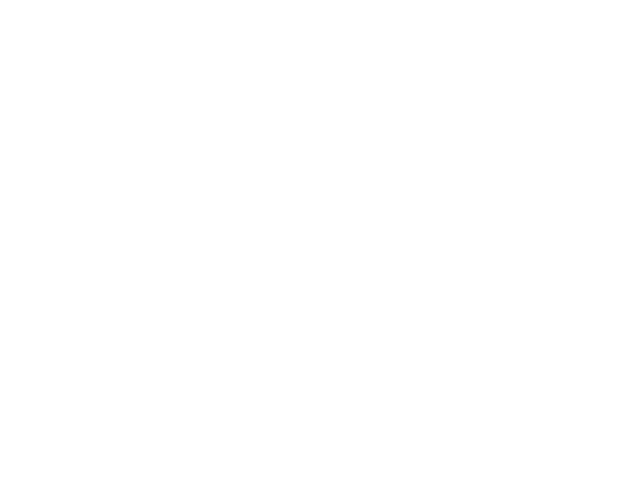

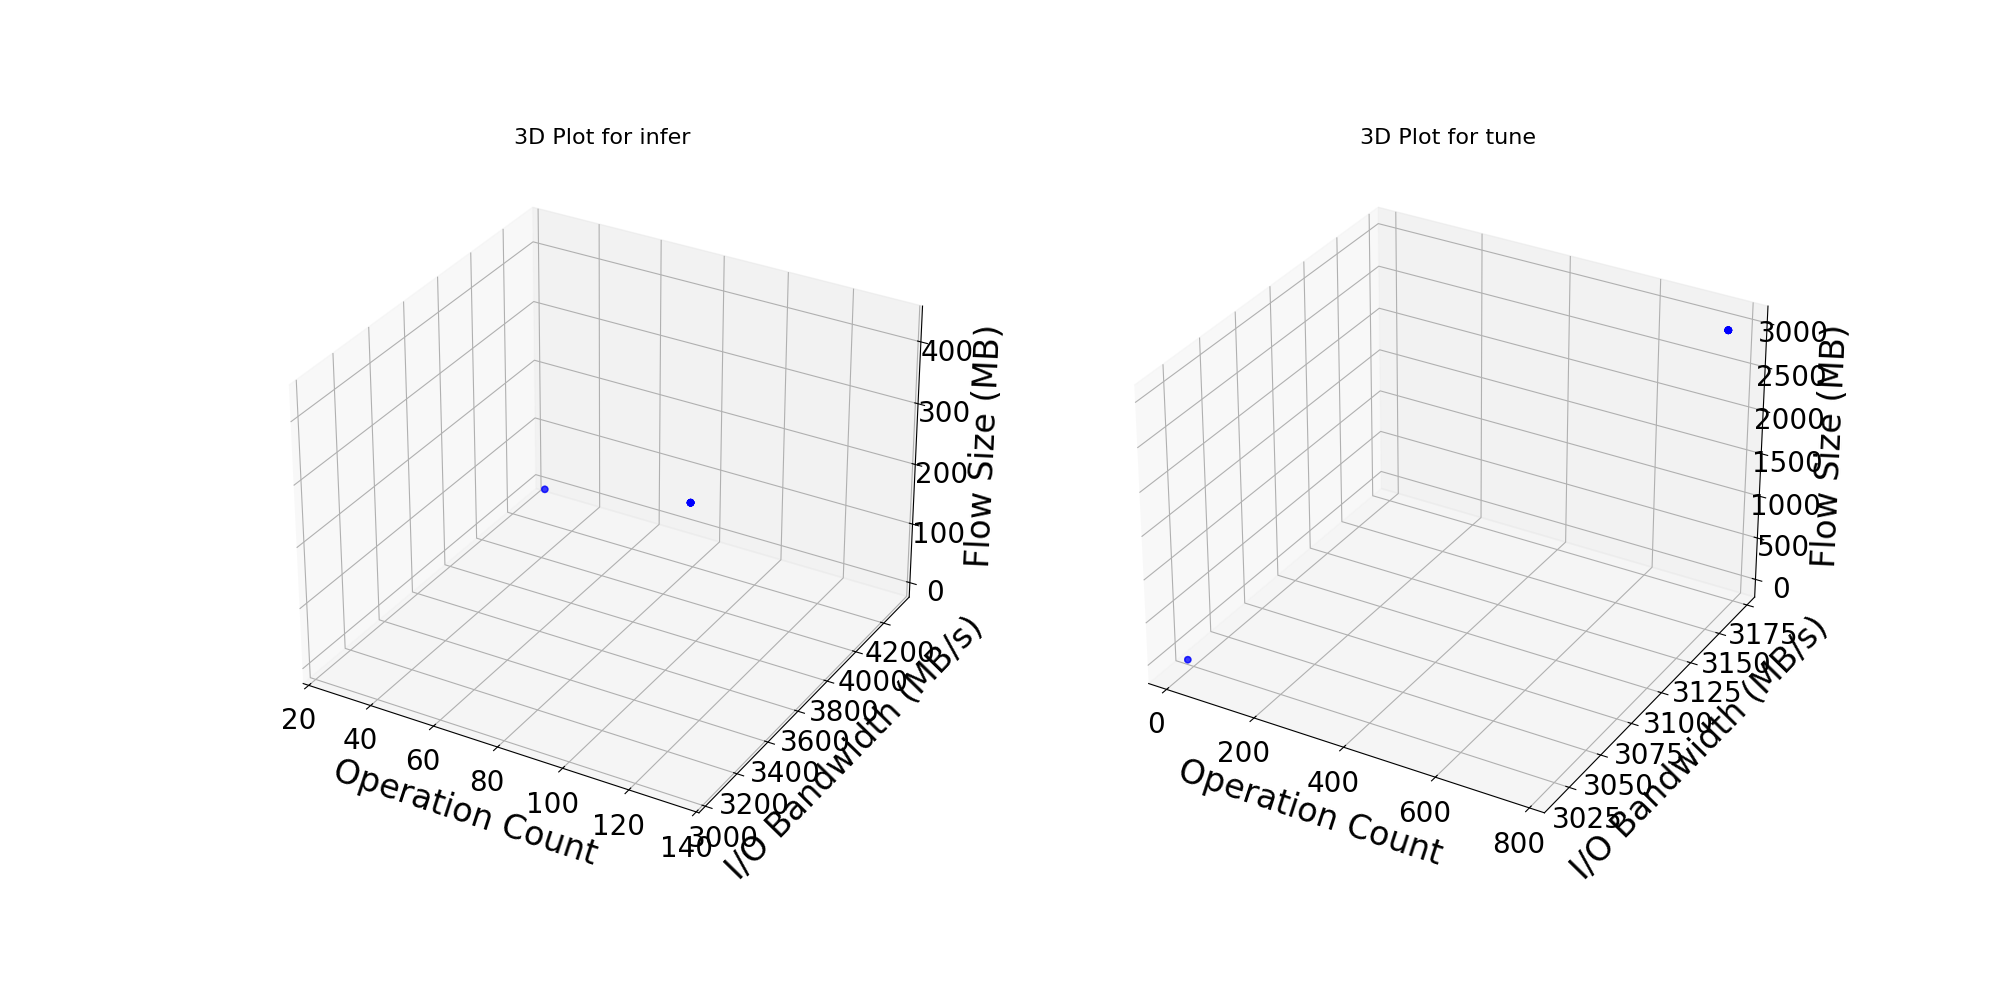

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

x = df['trMiB']
y = df['opCount']
z = df['aggregateFilesizeMB']

# Generate a color palette
unique_tasks = df['taskName'].unique()
num_tasks = len(unique_tasks)

# Set the font sizes for various plot elements
plt.rc('font', size=18)             # Default text size
plt.rc('axes', titlesize=16)        # Axes title font size
plt.rc('axes', labelsize=24)        # Axes label font size
plt.rc('xtick', labelsize=20)       # X-tick label font size
plt.rc('ytick', labelsize=20)       # Y-tick label font size
plt.rc('legend', fontsize=16)       # Legend font size

# Determine the grid layout based on the number of tasks
num_cols = min(3, num_tasks)  # Max 3 columns per row
num_rows = int(np.ceil(num_tasks / num_cols))  # Calculate required rows

# Create a figure and define the GridSpec
fig = plt.figure(figsize=(num_cols * 10, num_rows * 10))
gs = gridspec.GridSpec(num_rows, num_cols)

# Generate grid positions dynamically
task_indices = [(i // num_cols, i % num_cols) for i in range(num_tasks)]

for i, (task, (row, col)) in enumerate(zip(unique_tasks, task_indices)):
    subset = df[df['taskName'] == task]
    ax = fig.add_subplot(gs[row, col], projection='3d')
    ax.scatter(subset['opCount'], subset['trMiB'], subset['aggregateFilesizeMB'], 
               label=shorten_task_name(task), 
               color='b')
    ax.set_title(f'3D Plot for {task}')
    ax.set_ylabel('I/O Bandwidth (MB/s)', labelpad=10)
    ax.set_xlabel('Operation Count', labelpad=13)
    ax.set_zlabel('Flow Size (MB)', labelpad=10)

plt.figure(constrained_layout=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4) 
plt.show()
fig.savefig(f'{result_path}/tasksubplot_' + plot_file_name)

/tmp/ipykernel_440661/1860292298.py:41: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.4)


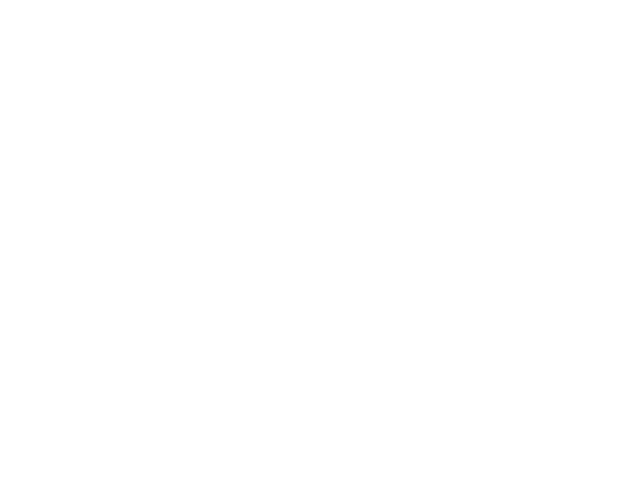

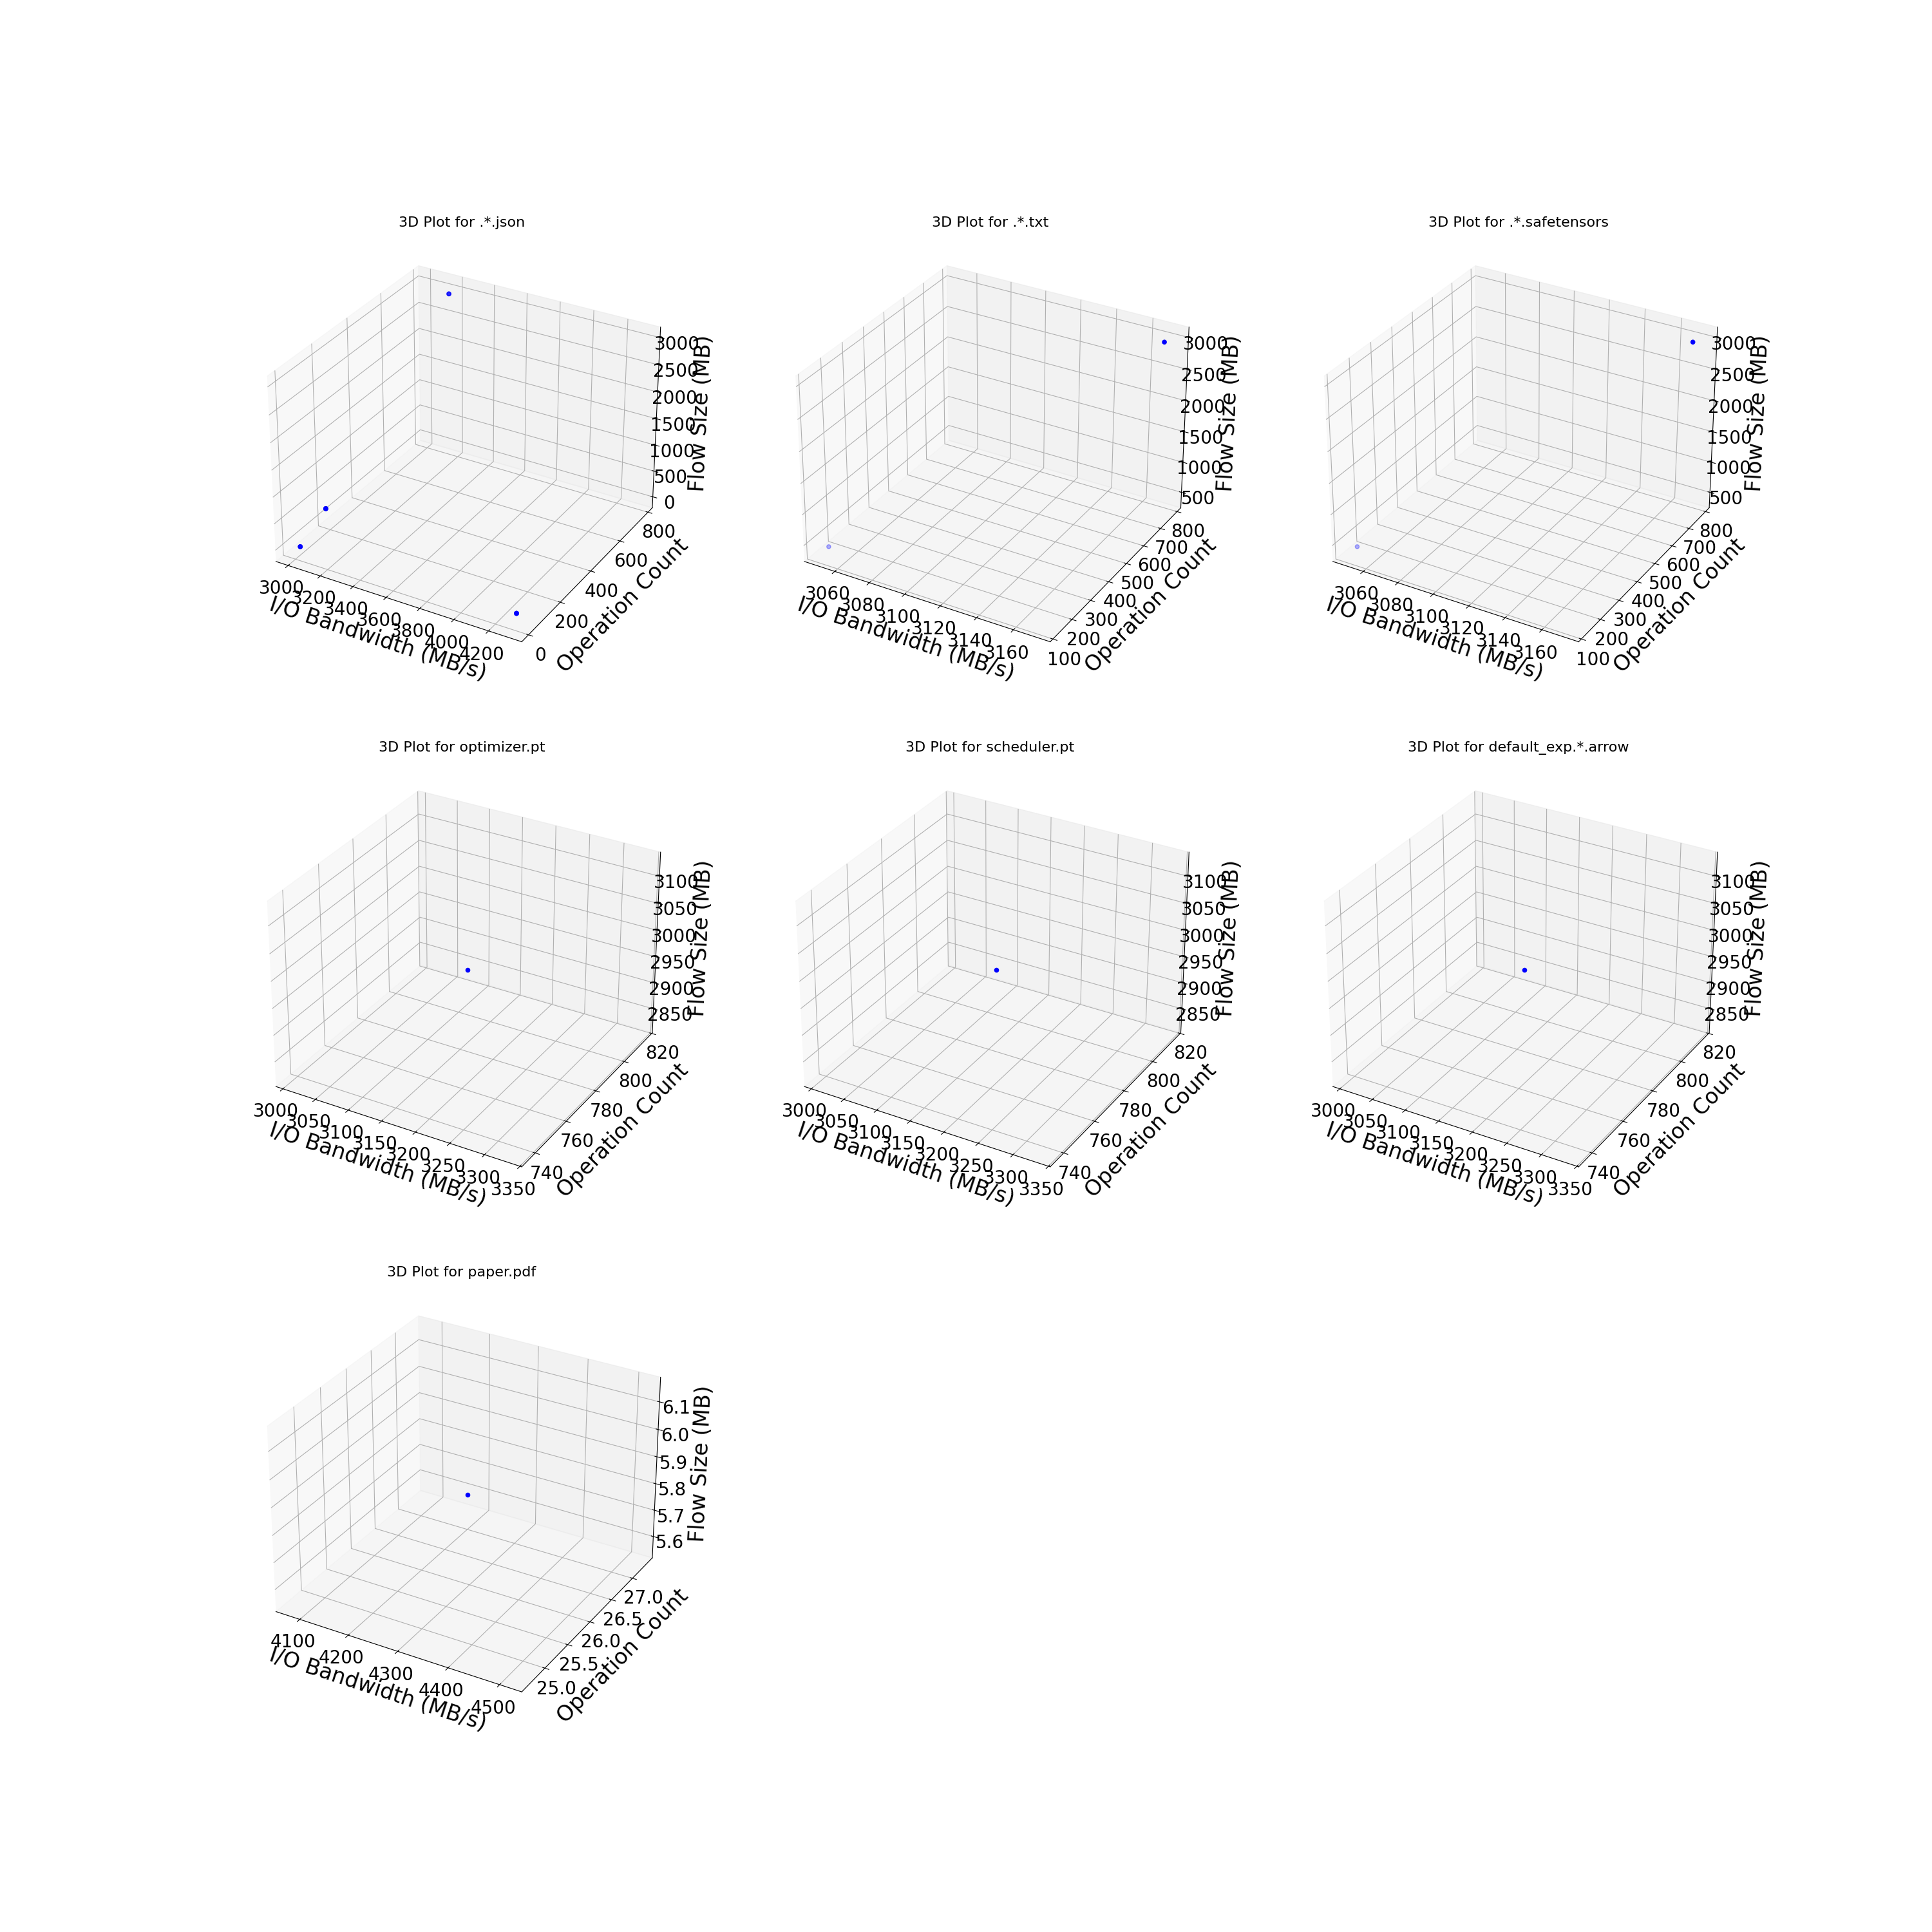

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# Generate a color palette
unique_filegroup = df['file_group'].unique()
num_filegroups = len(unique_filegroup)

# Set the font sizes for various plot elements
plt.rc('font', size=18)             # Default text size
plt.rc('axes', titlesize=16)        # Axes title font size
plt.rc('axes', labelsize=24)        # Axes label font size
plt.rc('xtick', labelsize=20)       # X-tick label font size
plt.rc('ytick', labelsize=20)       # Y-tick label font size
plt.rc('legend', fontsize=16)       # Legend font size

# Determine the grid layout based on the number of unique file groups
num_cols = min(3, num_filegroups)  # Max 3 columns per row
num_rows = int(np.ceil(num_filegroups / num_cols))  # Calculate required rows

# Create a figure and define the GridSpec
fig = plt.figure(figsize=(num_cols * 10, num_rows * 10))
gs = gridspec.GridSpec(num_rows, num_cols)

# Generate grid positions dynamically
task_indices = [(i // num_cols, i % num_cols) for i in range(num_filegroups)]

for i, (file, (row, col)) in enumerate(zip(unique_filegroup, task_indices)):
    subset = df[df['file_group'] == file]
    ax = fig.add_subplot(gs[row, col], projection='3d')
    ax.scatter(subset['trMiB'], subset['opCount'], subset['aggregateFilesizeMB'], 
               label=file, 
               color='b')
    ax.set_title(f'3D Plot for {file}')
    ax.set_xlabel('I/O Bandwidth (MB/s)', labelpad=10)
    ax.set_ylabel('Operation Count', labelpad=13)
    ax.set_zlabel('Flow Size (MB)', labelpad=10)

plt.figure(constrained_layout=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4) 
plt.show()
fig.savefig(f'{result_path}/filegroup_subplot_op_' + plot_file_name)

/tmp/ipykernel_440661/4260203375.py:42: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  plt.subplots_adjust(hspace=0.4, wspace=0.4)


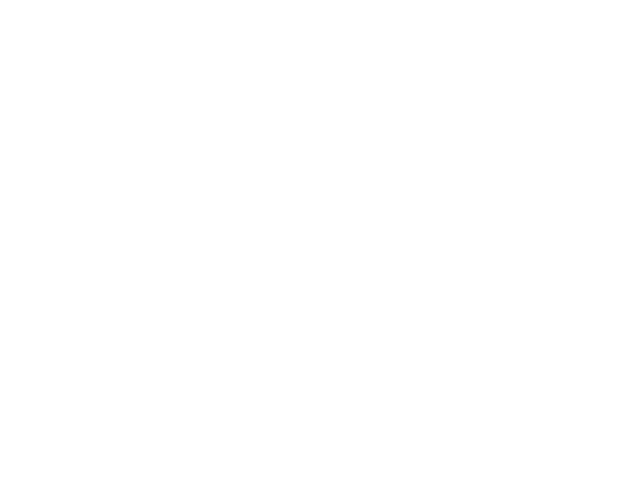

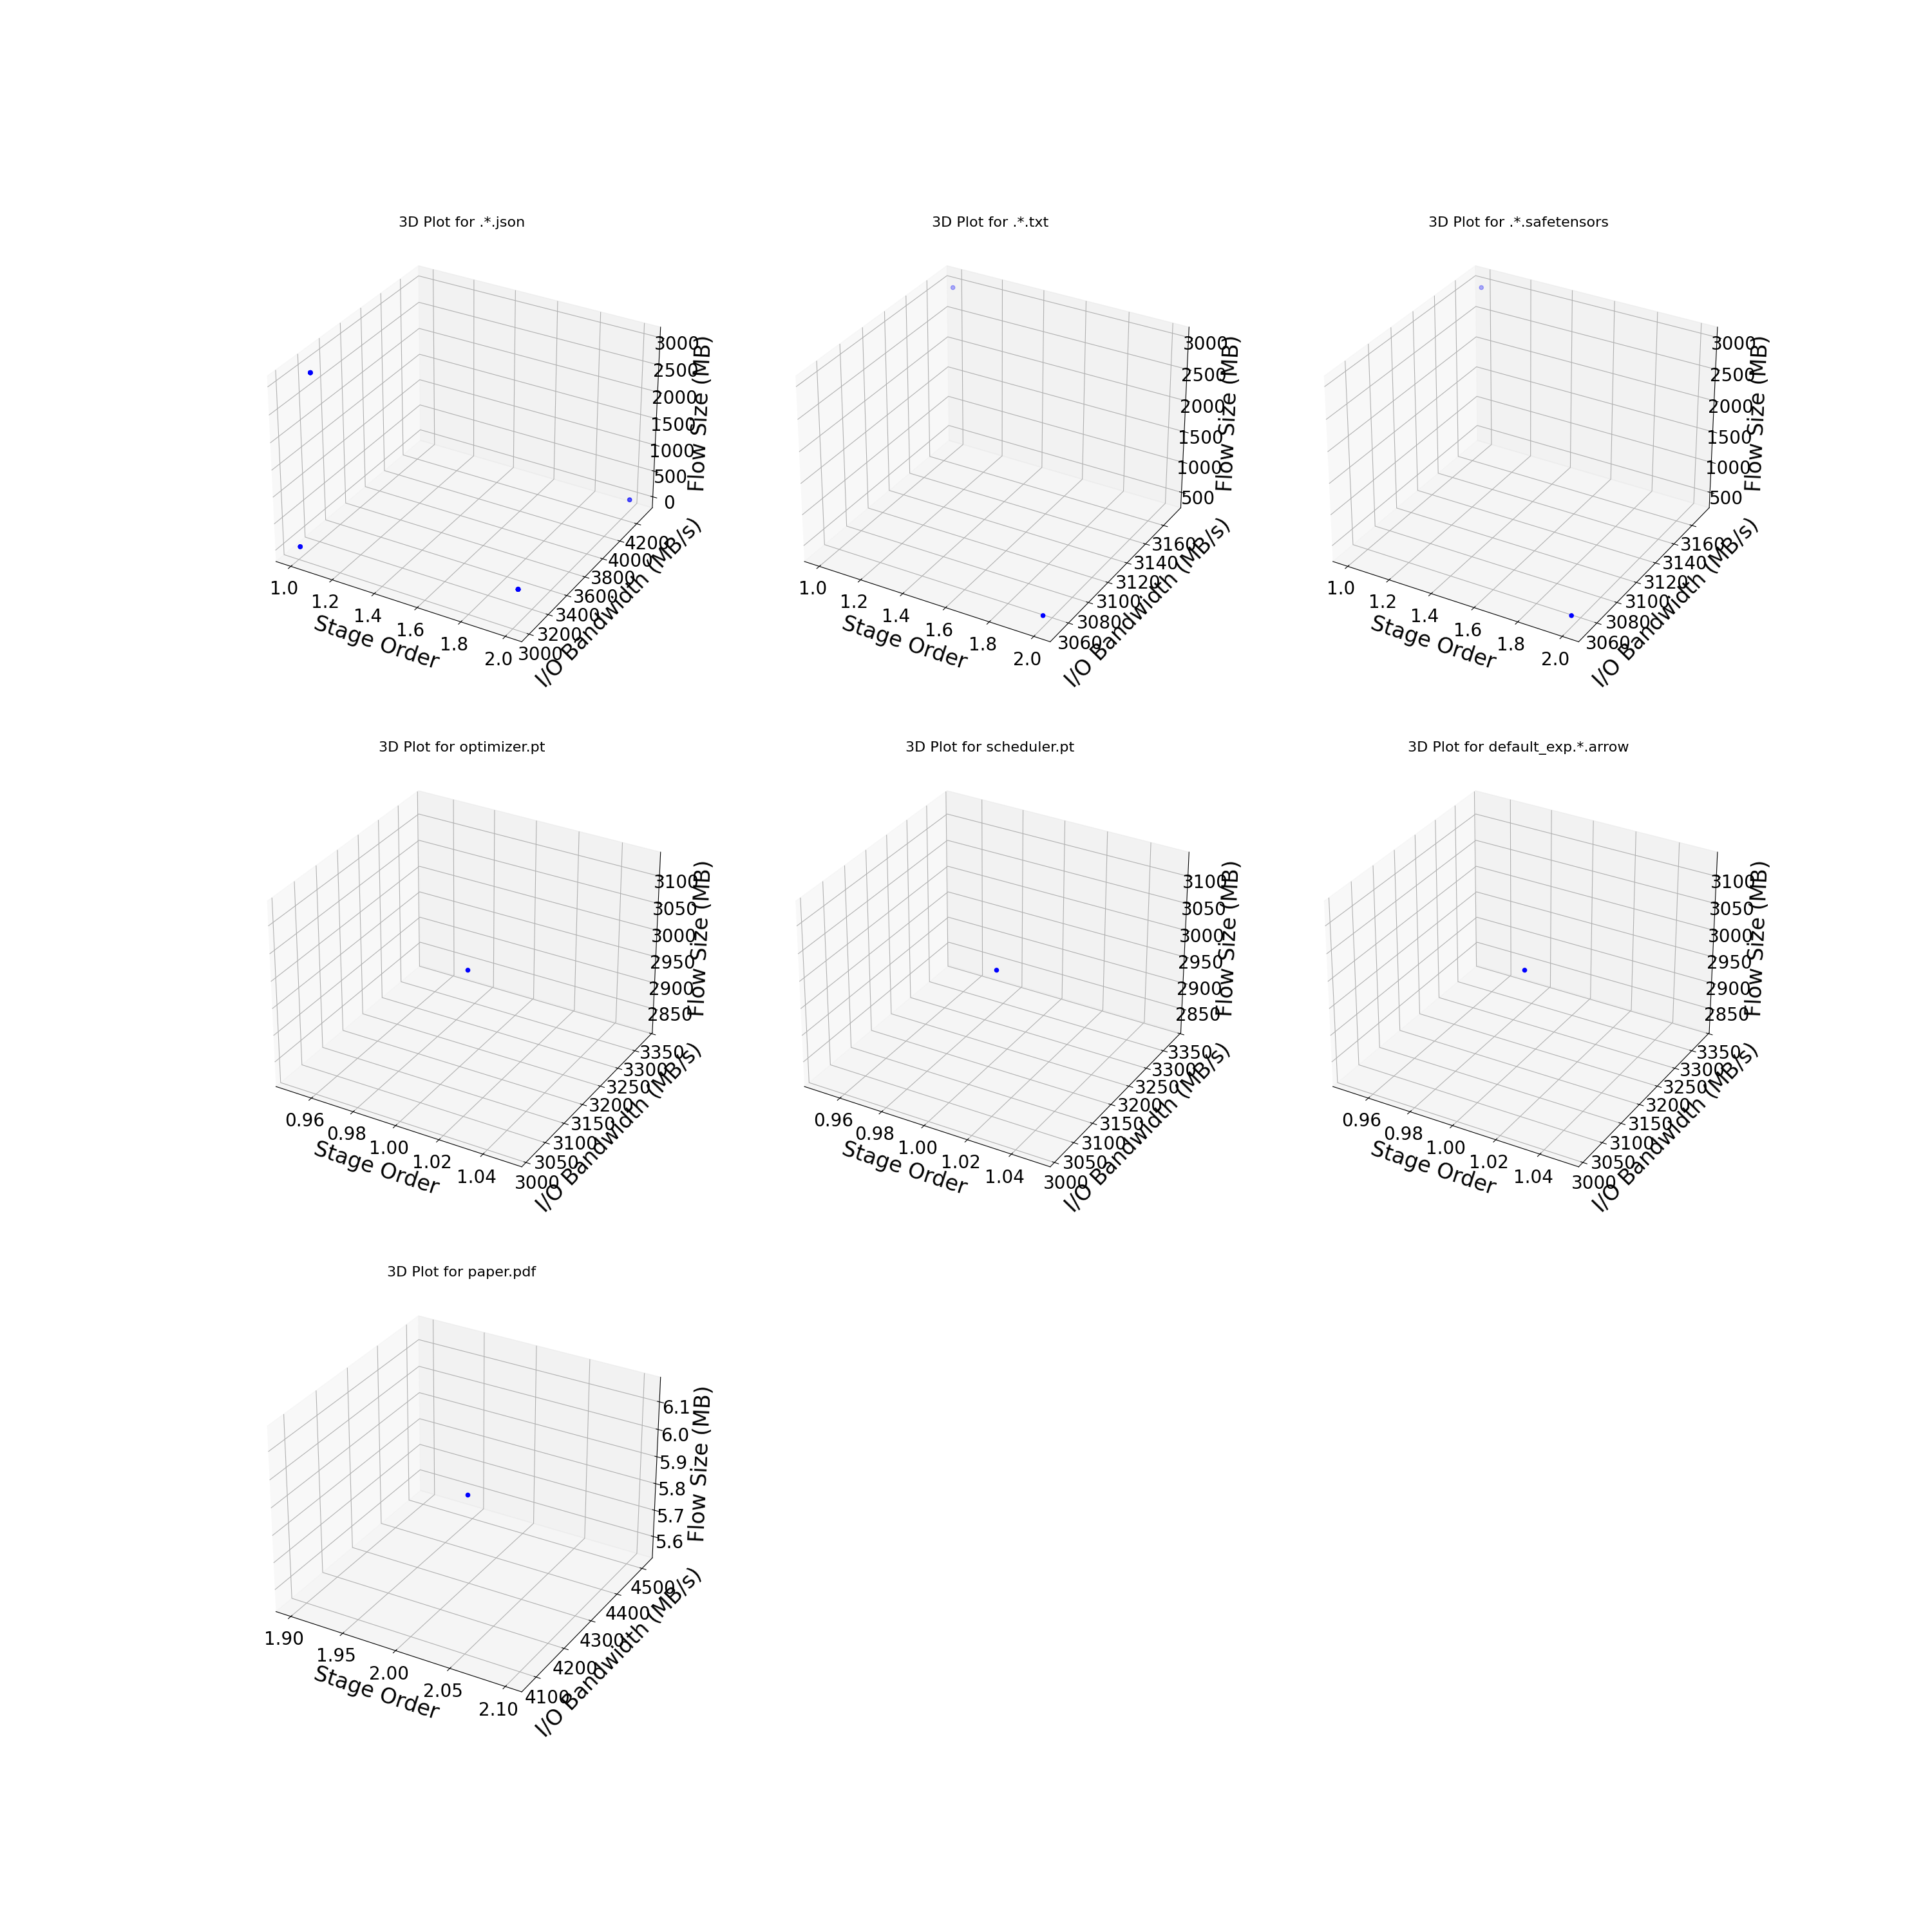

In [29]:
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np


# Generate a color palette
unique_filegroup = df['file_group'].unique()
num_filegroups = len(unique_filegroup)

# Set the font sizes for various plot elements
plt.rc('font', size=18)             # Default text size
plt.rc('axes', titlesize=16)        # Axes title font size
plt.rc('axes', labelsize=24)        # Axes label font size
plt.rc('xtick', labelsize=20)       # X-tick label font size
plt.rc('ytick', labelsize=20)       # Y-tick label font size
plt.rc('legend', fontsize=16)       # Legend font size

# Determine the grid layout based on the number of unique file groups
num_cols = min(3, num_filegroups)  # Max 3 columns per row
num_rows = int(np.ceil(num_filegroups / num_cols))  # Calculate required rows

# Create a figure and define the GridSpec
fig = plt.figure(figsize=(num_cols * 10, num_rows * 10))
gs = gridspec.GridSpec(num_rows, num_cols)

# Generate grid positions dynamically
task_indices = [(i // num_cols, i % num_cols) for i in range(num_filegroups)]

for i, (file, (row, col)) in enumerate(zip(unique_filegroup, task_indices)):
    subset = df[df['file_group'] == file]
    ax = fig.add_subplot(gs[row, col], projection='3d')
    ax.scatter(subset['stageOrder'], subset['trMiB'], subset['aggregateFilesizeMB'], 
               label=file, 
               color='b')
    ax.set_title(f'3D Plot for {file}')
    ax.set_ylabel('I/O Bandwidth (MB/s)', labelpad=10)
    ax.set_xlabel('Stage Order', labelpad=13)
    ax.set_zlabel('Flow Size (MB)', labelpad=10)

plt.figure(constrained_layout=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4) 
plt.show()
fig.savefig(f'{result_path}/filegroup_subplot_stage_' + plot_file_name)

In [30]:
df.columns, df['stageOrder'].unique()

(Index(['operation', 'randomOffset', 'transferSize', 'aggregateFilesizeMB',
        'numTasks', 'parallelism', 'totalTime', 'numNodesList', 'numNodes',
        'tasksPerNode', 'trMiB', 'storageType', 'opCount', 'taskName',
        'taskPID', 'fileName', 'stageOrder', 'prevTask',
        'estimated_trMiB_ssd_p', 'estimated_trMiB_beegfs_p',
        'estimated_trMiB_ssd_1p', 'estimated_ts_slope_ssd_1p',
        'estimated_trMiB_beegfs_1p', 'estimated_ts_slope_beegfs_1p', 'io_type',
        'color', 'marker', 'file_group'],
       dtype='object'),
 array([2, 1]))